原始网络的最短路径和: 383.05722914981766


Population=300:   0%|          | 0/120 [00:00<?, ?it/s]

Completed: Pop=300, Select=0.3333333333333333, Mutate=0.05 - Final Fitness=363.20598505395003
Completed: Pop=300, Select=0.3333333333333333, Mutate=0.15 - Final Fitness=360.2767001028802
Completed: Pop=300, Select=0.3333333333333333, Mutate=0.1 - Final Fitness=356.99707763295316


/home/huanghanjun/anaconda3/envs/graph-tool/lib/python3.12/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


Completed: Pop=300, Select=0.5, Mutate=0.05 - Final Fitness=364.83836486778677
Completed: Pop=300, Select=0.5, Mutate=0.1 - Final Fitness=359.69303714662084
Completed: Pop=300, Select=0.5, Mutate=0.15 - Final Fitness=355.4970304023541
Completed: Pop=300, Select=0.6666666666666666, Mutate=0.05 - Final Fitness=367.8863495071313
Completed: Pop=300, Select=0.6666666666666666, Mutate=0.1 - Final Fitness=363.7125772527831
Completed: Pop=300, Select=0.75, Mutate=0.05 - Final Fitness=370.9460434218862
Completed: Pop=300, Select=0.6666666666666666, Mutate=0.15 - Final Fitness=361.1064121661119
Completed: Pop=300, Select=0.75, Mutate=0.1 - Final Fitness=362.7560641348325
Completed: Pop=300, Select=0.75, Mutate=0.15 - Final Fitness=368.5126233841728


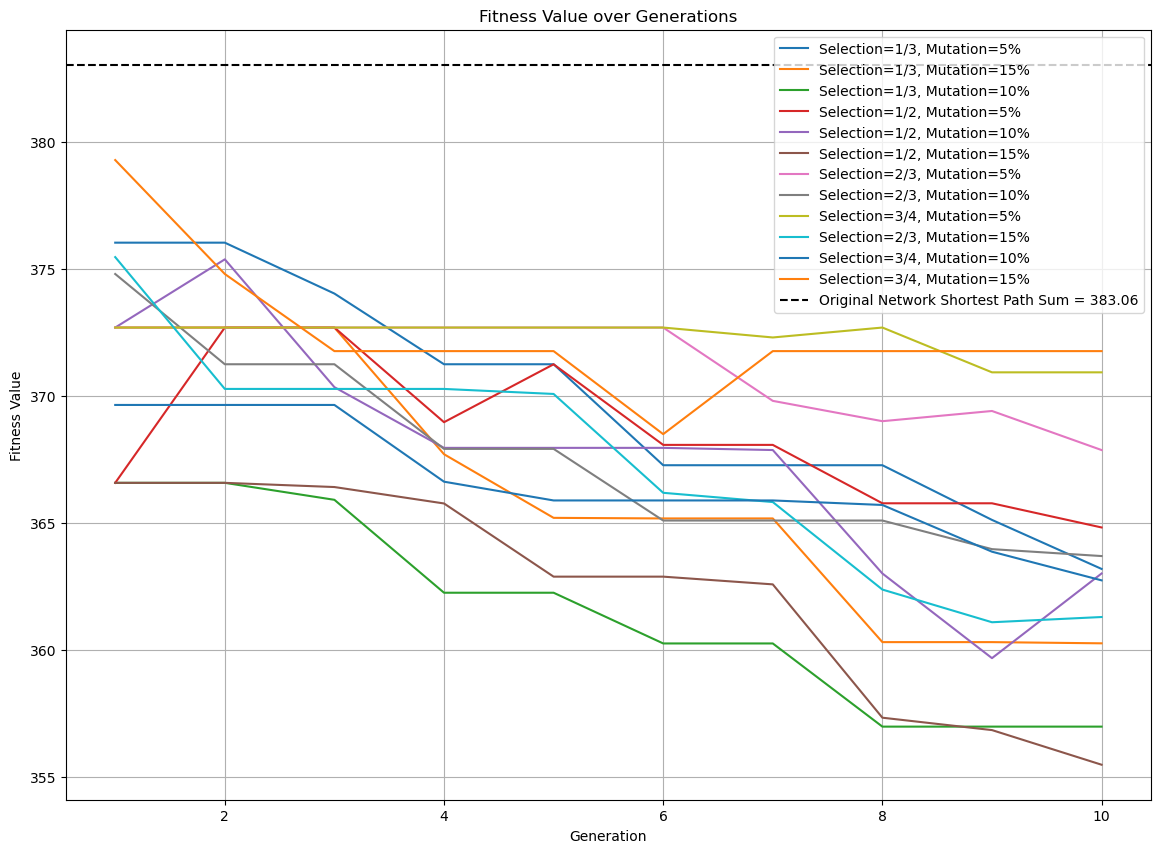

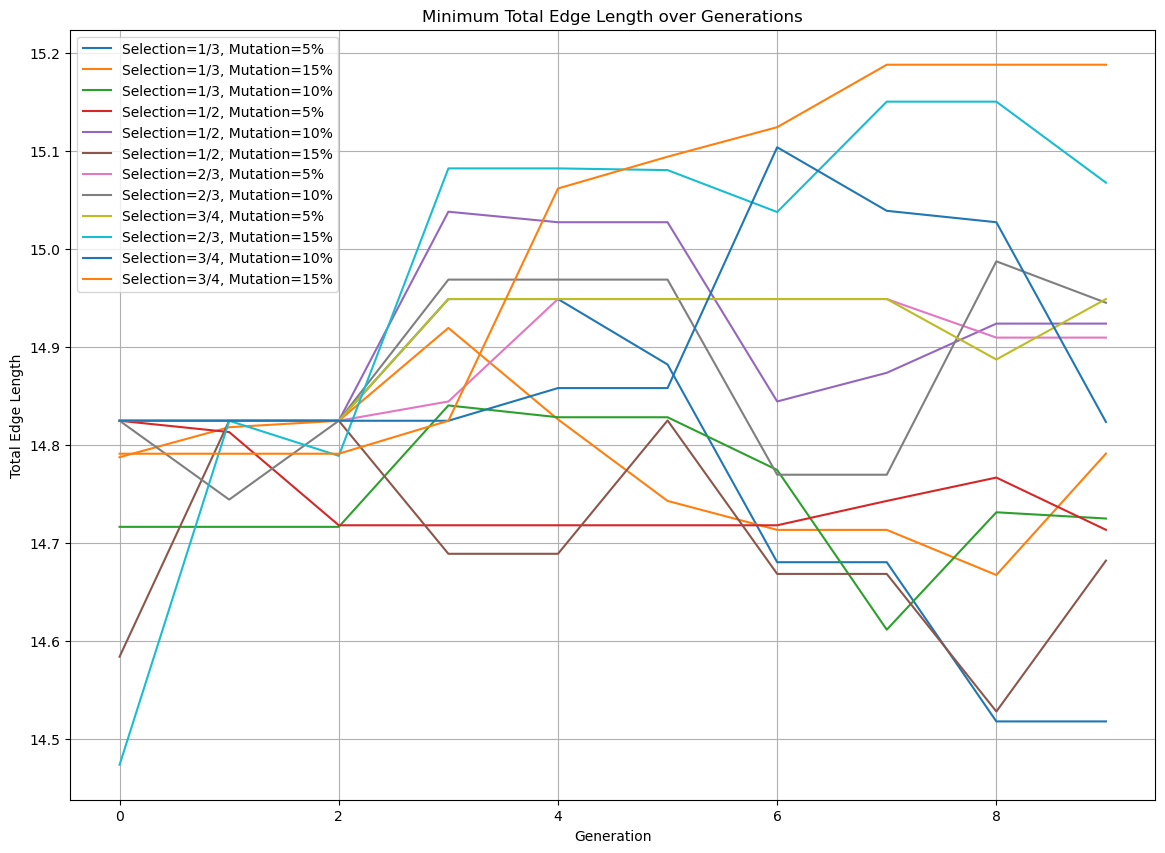

In [1]:
import numpy as np
from graph_tool.all import shortest_distance
from deap import base, creator, tools, algorithms
import python_codes.files_operators as fo
import matplotlib.pyplot as plt
from concurrent.futures import ThreadPoolExecutor, as_completed
from fractions import Fraction
from tqdm.notebook import tqdm
import python_codes.newga_utils as ga  # 调整后的导入路径

# 读取图和位置信息
filename1 = "ATT_US_Norm"
read_graph, read_pos = fo.read_files(f"../networks_clusters/{filename1}.net")
num_edges = read_graph.num_edges()

# 计算并添加边的欧氏距离作为权重属性
edge_weights = read_graph.new_edge_property("double")
for edge in read_graph.edges():
    source_pos = read_pos[edge.source()]
    target_pos = read_pos[edge.target()]
    euclidean_distance = np.sqrt((source_pos[0] - target_pos[0]) ** 2 + (source_pos[1] - target_pos[1]) ** 2)
    edge_weights[edge] = euclidean_distance

# 计算原始网络的最短路径和
dist_matrix = shortest_distance(read_graph, weights=edge_weights).get_2d_array(range(read_graph.num_vertices()))
original_network_value = np.sum(dist_matrix[dist_matrix != np.inf])
print(f"原始网络的最短路径和: {original_network_value}")

# 创建个体和适应度
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)

# 注册工具箱
toolbox = base.Toolbox()
toolbox.register("individual", ga.init_individual, read_graph=read_graph, edge_weights=edge_weights,
                 num_edges=num_edges)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("evaluate", ga.evaluate, read_graph=read_graph, read_pos=read_pos, edge_weights=edge_weights)
toolbox.register("mate", ga.cxGraph, num_edges=num_edges)
toolbox.register("mutate", ga.mutGraph, num_edges=num_edges)
toolbox.register("select", tools.selTournament, tournsize=3)


# 主遗传算法流程，记录最小适应度值和边总长度最小值
def main(population_size, selection_ratio, mutpb, initial_population, pbar, num_generations):
    num_selected = int(population_size * selection_ratio)
    num_offspring = population_size - num_selected
    cxpb = 0.5
    pop = initial_population[:]
    hof = tools.HallOfFame(1)
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("min", np.min)
    logbook = tools.Logbook()
    logbook.header = ["gen", "min"]

    # 新增记录边总长度的数组
    edge_length_min_values = []

    for gen in range(num_generations):
        # 选择操作
        selected = toolbox.select(pop, num_selected)
        # 生成新的个体
        offspring = algorithms.varAnd(selected, toolbox, cxpb, mutpb)
        offspring = offspring[:num_offspring]
        # 更新种群
        pop[:] = selected + offspring
        # 评估适应度
        fitnesses = list(map(toolbox.evaluate, pop))
        for ind, fit in zip(pop, fitnesses):
            ind.fitness.values = fit
        # 记录和输出每一代的最优适应度值
        record = stats.compile(pop)
        logbook.record(gen=gen, **record)
        pbar.update(1)
        hof.update(pop)

        # 找到每一代中边的总长度最小的个体
        min_edge_length = float('inf')
        for ind in pop:
            graph, new_edge_weights = ga.individual_to_graph(ind, read_graph.num_vertices(), read_pos)
            total_edge_length = np.sum([new_edge_weights[edge] for edge in graph.edges()])
            if total_edge_length < min_edge_length:
                min_edge_length = total_edge_length
        edge_length_min_values.append(min_edge_length)  # 保存最小边总长度

    return logbook, hof[0].fitness.values[0], edge_length_min_values


# 参数配置
num_generations = 10
population_sizes = [300]
selection_ratios = [1 / 3, 1 / 2, 2 / 3, 3 / 4]
mutation_probs = [0.05, 0.1, 0.15]
progress_bars = {
    pop_size: tqdm(total=12 * num_generations, desc=f'Population={pop_size}', position=i, leave=True)
    for i, pop_size in enumerate(population_sizes)
}

# 执行主流程
initial_population = toolbox.population(n=population_sizes[0])
fitnesses = list(map(toolbox.evaluate, initial_population))
initial_fitness = min(fitnesses)[0]
all_logbooks = []
all_edge_lengths = []

# 执行每个种群大小的实验并绘图
for population_size in population_sizes:
    initial_population = toolbox.population(n=population_size)
    fitnesses = list(map(toolbox.evaluate, initial_population))
    initial_fitness = min(fitnesses)[0]

    with ThreadPoolExecutor(max_workers=4) as executor:
        future_to_params = {
            executor.submit(main, population_size, selection_ratio, mutpb, initial_population,
                            progress_bars[population_size], num_generations): (
                selection_ratio, mutpb)
            for selection_ratio in selection_ratios
            for mutpb in mutation_probs
        }

        for future in as_completed(future_to_params):
            selection_ratio, mutpb = future_to_params[future]
            try:
                logbook, final_fitness, edge_length_min_values = future.result()
                all_logbooks.append((logbook, selection_ratio, mutpb))
                all_edge_lengths.append((edge_length_min_values, selection_ratio, mutpb))

                print(
                    f'Completed: Pop={population_size}, Select={selection_ratio}, Mutate={mutpb} - Final Fitness={final_fitness}')

            except Exception as ex:
                print(f'Error with Pop={population_size}, Select={selection_ratio}, Mutate={mutpb}: {ex}')

# 绘制适应度值随代数的变化图
plt.figure(figsize=(14, 10))
for logbook, selection_ratio, mutpb in all_logbooks:
    min_fitness_values = logbook.select("min")
    generations = list(range(1, len(min_fitness_values) + 1))
    fitness_values = [initial_fitness] + min_fitness_values
    generations = [0] + generations

    plt.plot(generations, fitness_values,
             label=f'Selection={Fraction(selection_ratio).limit_denominator()}, Mutation={int(mutpb * 100)}%')

# 在图表上添加原始网络的最短路径和
plt.axhline(y=original_network_value, color='k', linestyle='--',
            label=f'Original Network Shortest Path Sum = {original_network_value:.2f}')
plt.title("Fitness Value over Generations")
plt.xlabel("Generation")
plt.ylabel("Fitness Value")
plt.legend()
plt.grid(True)
plt.show()

# 新增：绘制每代最小边总长度变化图
plt.figure(figsize=(14, 10))
for edge_length_min_values, selection_ratio, mutpb in all_edge_lengths:
    generations = list(range(num_generations))
    plt.plot(generations, edge_length_min_values,
             label=f'Selection={Fraction(selection_ratio).limit_denominator()}, Mutation={int(mutpb * 100)}%')

plt.title("Minimum Total Edge Length over Generations")
plt.xlabel("Generation")
plt.ylabel("Total Edge Length")
plt.legend()
plt.grid(True)
plt.show()


原始网络的最短路径和: 383.05722914981766
原始网络的边的总长度: 14.948198914997414


/home/huanghanjun/anaconda3/envs/graph-tool/lib/python3.12/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/huanghanjun/anaconda3/envs/graph-tool/lib/python3.12/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


Population=300:   0%|          | 0/120 [00:00<?, ?it/s]

Completed: Pop=300, Select=0.3333333333333333, Mutate=0.15 - Final Fitness=357.47307863046353
Completed: Pop=300, Select=0.3333333333333333, Mutate=0.1 - Final Fitness=357.2833586805179
Completed: Pop=300, Select=0.3333333333333333, Mutate=0.05 - Final Fitness=359.83942073742173
Completed: Pop=300, Select=0.5, Mutate=0.05 - Final Fitness=358.571191925859
Completed: Pop=300, Select=0.6666666666666666, Mutate=0.05 - Final Fitness=356.09034926996986
Completed: Pop=300, Select=0.5, Mutate=0.1 - Final Fitness=361.06104993516243
Completed: Pop=300, Select=0.5, Mutate=0.15 - Final Fitness=357.23511485553746
Completed: Pop=300, Select=0.6666666666666666, Mutate=0.1 - Final Fitness=364.402166056844
Completed: Pop=300, Select=0.6666666666666666, Mutate=0.15 - Final Fitness=362.14796817806246
Completed: Pop=300, Select=0.75, Mutate=0.05 - Final Fitness=362.305980741334
Completed: Pop=300, Select=0.75, Mutate=0.1 - Final Fitness=367.0134298528502
Completed: Pop=300, Select=0.75, Mutate=0.15 - Fina

/tmp/ipykernel_67804/3611375515.py:141: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_map = cm.get_cmap("Blues")  # 使用蓝色色系


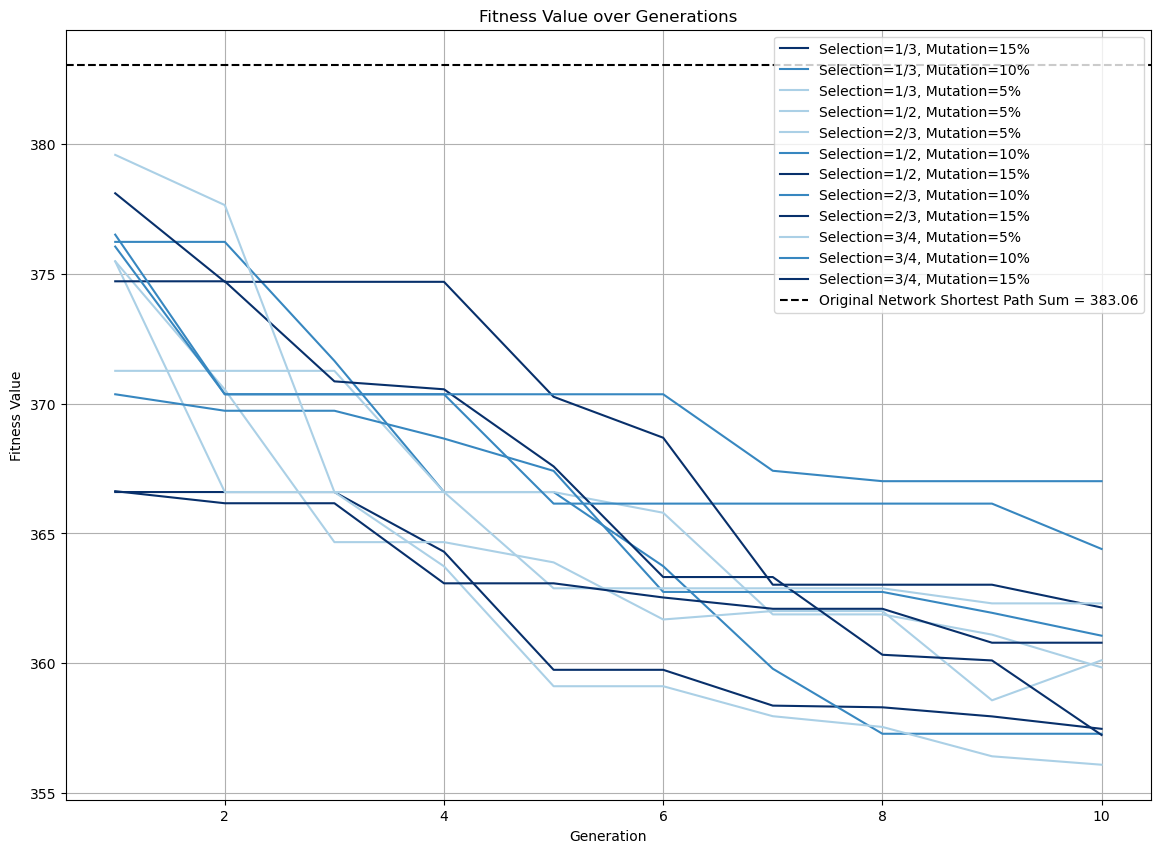

/tmp/ipykernel_67804/3611375515.py:168: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_map = cm.get_cmap("Greens")  # 使用绿色色系


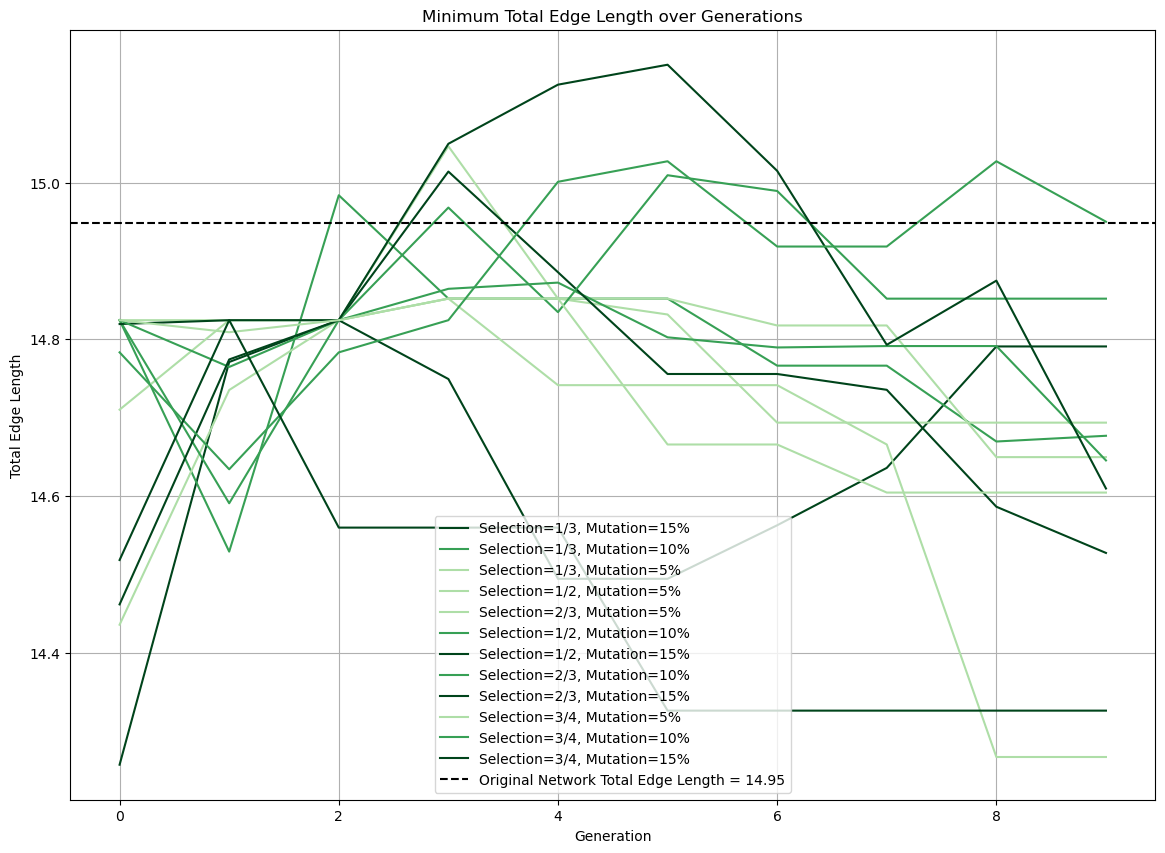

In [2]:
import numpy as np
from graph_tool.all import shortest_distance
from deap import base, creator, tools, algorithms
import python_codes.files_operators as fo
import matplotlib.pyplot as plt
from concurrent.futures import ThreadPoolExecutor, as_completed
from fractions import Fraction
from tqdm.notebook import tqdm
import matplotlib.cm as cm  # 用于色系映射
import python_codes.newga_utils as ga  # 调整后的导入路径

# 读取图和位置信息
filename1 = "ATT_US_Norm"
read_graph, read_pos = fo.read_files(f"../networks_clusters/{filename1}.net")
num_edges = read_graph.num_edges()

# 计算并添加边的欧氏距离作为权重属性
edge_weights = read_graph.new_edge_property("double")
for edge in read_graph.edges():
    source_pos = read_pos[edge.source()]
    target_pos = read_pos[edge.target()]
    euclidean_distance = np.sqrt((source_pos[0] - target_pos[0]) ** 2 + (source_pos[1] - target_pos[1]) ** 2)
    edge_weights[edge] = euclidean_distance

# 计算原始网络的最短路径和
dist_matrix = shortest_distance(read_graph, weights=edge_weights).get_2d_array(range(read_graph.num_vertices()))
original_network_value = np.sum(dist_matrix[dist_matrix != np.inf])
print(f"原始网络的最短路径和: {original_network_value}")

# 计算原始网络的边的总长度
original_total_edge_length = np.sum([edge_weights[edge] for edge in read_graph.edges()])
print(f"原始网络的边的总长度: {original_total_edge_length}")

# 创建个体和适应度
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)

# 注册工具箱
toolbox = base.Toolbox()
toolbox.register("individual", ga.init_individual, read_graph=read_graph, edge_weights=edge_weights,
                 num_edges=num_edges)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("evaluate", ga.evaluate, read_graph=read_graph, read_pos=read_pos, edge_weights=edge_weights)
toolbox.register("mate", ga.cxGraph, num_edges=num_edges)
toolbox.register("mutate", ga.mutGraph, num_edges=num_edges)
toolbox.register("select", tools.selTournament, tournsize=3)


# 主遗传算法流程，记录最小适应度值和边总长度最小值
def main(population_size, selection_ratio, mutpb, initial_population, pbar, num_generations):
    num_selected = int(population_size * selection_ratio)
    num_offspring = population_size - num_selected
    cxpb = 0.5
    pop = initial_population[:]
    hof = tools.HallOfFame(1)
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("min", np.min)
    logbook = tools.Logbook()
    logbook.header = ["gen", "min"]

    # 新增记录边总长度的数组
    edge_length_min_values = []

    for gen in range(num_generations):
        # 选择操作
        selected = toolbox.select(pop, num_selected)
        # 生成新的个体
        offspring = algorithms.varAnd(selected, toolbox, cxpb, mutpb)
        offspring = offspring[:num_offspring]
        # 更新种群
        pop[:] = selected + offspring
        # 评估适应度
        fitnesses = list(map(toolbox.evaluate, pop))
        for ind, fit in zip(pop, fitnesses):
            ind.fitness.values = fit
        # 记录和输出每一代的最优适应度值
        record = stats.compile(pop)
        logbook.record(gen=gen, **record)
        pbar.update(1)
        hof.update(pop)

        # 找到每一代中边的总长度最小的个体
        min_edge_length = float('inf')
        for ind in pop:
            graph, new_edge_weights = ga.individual_to_graph(ind, read_graph.num_vertices(), read_pos)
            total_edge_length = np.sum([new_edge_weights[edge] for edge in graph.edges()])
            if total_edge_length < min_edge_length:
                min_edge_length = total_edge_length
        edge_length_min_values.append(min_edge_length)  # 保存最小边总长度

    return logbook, hof[0].fitness.values[0], edge_length_min_values


# 参数配置
num_generations = 10
population_sizes = [300]
selection_ratios = [1 / 3, 1 / 2, 2 / 3, 3 / 4]
mutation_probs = [0.05, 0.1, 0.15]
progress_bars = {
    pop_size: tqdm(total=12 * num_generations, desc=f'Population={pop_size}', position=i, leave=True)
    for i, pop_size in enumerate(population_sizes)
}

# 执行主流程
initial_population = toolbox.population(n=population_sizes[0])
fitnesses = list(map(toolbox.evaluate, initial_population))
initial_fitness = min(fitnesses)[0]
all_logbooks = []
all_edge_lengths = []

# 执行每个种群大小的实验并绘图
for population_size in population_sizes:
    initial_population = toolbox.population(n=population_size)
    fitnesses = list(map(toolbox.evaluate, initial_population))
    initial_fitness = min(fitnesses)[0]

    with ThreadPoolExecutor(max_workers=4) as executor:
        future_to_params = {
            executor.submit(main, population_size, selection_ratio, mutpb, initial_population,
                            progress_bars[population_size], num_generations): (
                selection_ratio, mutpb)
            for selection_ratio in selection_ratios
            for mutpb in mutation_probs
        }

        for future in as_completed(future_to_params):
            selection_ratio, mutpb = future_to_params[future]
            try:
                logbook, final_fitness, edge_length_min_values = future.result()
                all_logbooks.append((logbook, selection_ratio, mutpb))
                all_edge_lengths.append((edge_length_min_values, selection_ratio, mutpb))

                print(
                    f'Completed: Pop={population_size}, Select={selection_ratio}, Mutate={mutpb} - Final Fitness={final_fitness}')

            except Exception as ex:
                print(f'Error with Pop={population_size}, Select={selection_ratio}, Mutate={mutpb}: {ex}')

# 绘制适应度值随代数的变化图
plt.figure(figsize=(14, 10))
color_map = cm.get_cmap("Blues")  # 使用蓝色色系
for logbook, selection_ratio, mutpb in all_logbooks:
    min_fitness_values = logbook.select("min")
    generations = list(range(1, len(min_fitness_values) + 1))
    fitness_values = [initial_fitness] + min_fitness_values
    generations = [0] + generations

    # 根据变异概率调整颜色深度
    color_intensity = (mutation_probs.index(mutpb) + 1) / len(mutation_probs)
    color = color_map(color_intensity)

    plt.plot(generations, fitness_values,
             label=f'Selection={Fraction(selection_ratio).limit_denominator()}, Mutation={int(mutpb * 100)}%',
             color=color)

# 在图表上添加原始网络的最短路径和
plt.axhline(y=original_network_value, color='k', linestyle='--',
            label=f'Original Network Shortest Path Sum = {original_network_value:.2f}')
plt.title("Fitness Value over Generations")
plt.xlabel("Generation")
plt.ylabel("Fitness Value")
plt.legend()
plt.grid(True)
plt.show()

# 新增：绘制每代最小边总长度变化图
plt.figure(figsize=(14, 10))
color_map = cm.get_cmap("Greens")  # 使用绿色色系
for edge_length_min_values, selection_ratio, mutpb in all_edge_lengths:
    generations = list(range(num_generations))

    # 根据变异概率调整颜色深度
    color_intensity = (mutation_probs.index(mutpb) + 1) / len(mutation_probs)
    color = color_map(color_intensity)

    plt.plot(generations, edge_length_min_values,
             label=f'Selection={Fraction(selection_ratio).limit_denominator()}, Mutation={int(mutpb * 100)}%',
             color=color)

# 在图表上添加原始网络的总边长度
plt.axhline(y=original_total_edge_length, color='k', linestyle='--',
            label=f'Original Network Total Edge Length = {original_total_edge_length:.2f}')
plt.title("Minimum Total Edge Length over Generations")
plt.xlabel("Generation")
plt.ylabel("Total Edge Length")
plt.legend()
plt.grid(True)
plt.show()


原始网络的最短路径和: 383.05722914981766
原始网络的边的总长度: 14.948198914997414


Population=300:   0%|          | 0/120 [00:00<?, ?it/s]

Completed: Pop=300, Select=0.3333333333333333, Mutate=0.15 - Final Fitness=359.8044463057847
Completed: Pop=300, Select=0.3333333333333333, Mutate=0.05 - Final Fitness=362.2837955908628
Completed: Pop=300, Select=0.3333333333333333, Mutate=0.1 - Final Fitness=363.5680163172765
Completed: Pop=300, Select=0.5, Mutate=0.05 - Final Fitness=361.640433269518
Completed: Pop=300, Select=0.6666666666666666, Mutate=0.05 - Final Fitness=363.59727023629785
Completed: Pop=300, Select=0.5, Mutate=0.1 - Final Fitness=353.04889034406426
Completed: Pop=300, Select=0.5, Mutate=0.15 - Final Fitness=357.37237204394035
Completed: Pop=300, Select=0.6666666666666666, Mutate=0.1 - Final Fitness=361.64659190872464
Completed: Pop=300, Select=0.75, Mutate=0.05 - Final Fitness=364.0176551155205
Completed: Pop=300, Select=0.6666666666666666, Mutate=0.15 - Final Fitness=361.6043589914741
Completed: Pop=300, Select=0.75, Mutate=0.1 - Final Fitness=366.3700016607483
Completed: Pop=300, Select=0.75, Mutate=0.15 - Fina

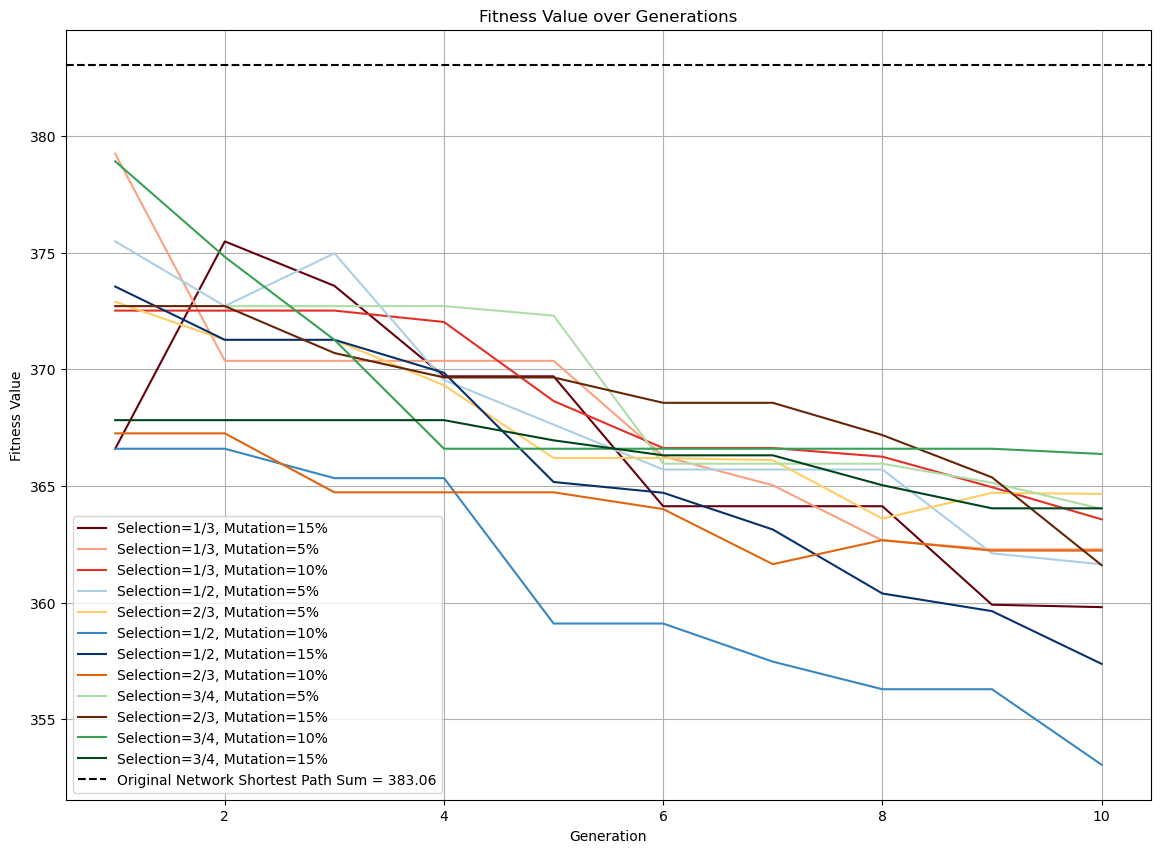

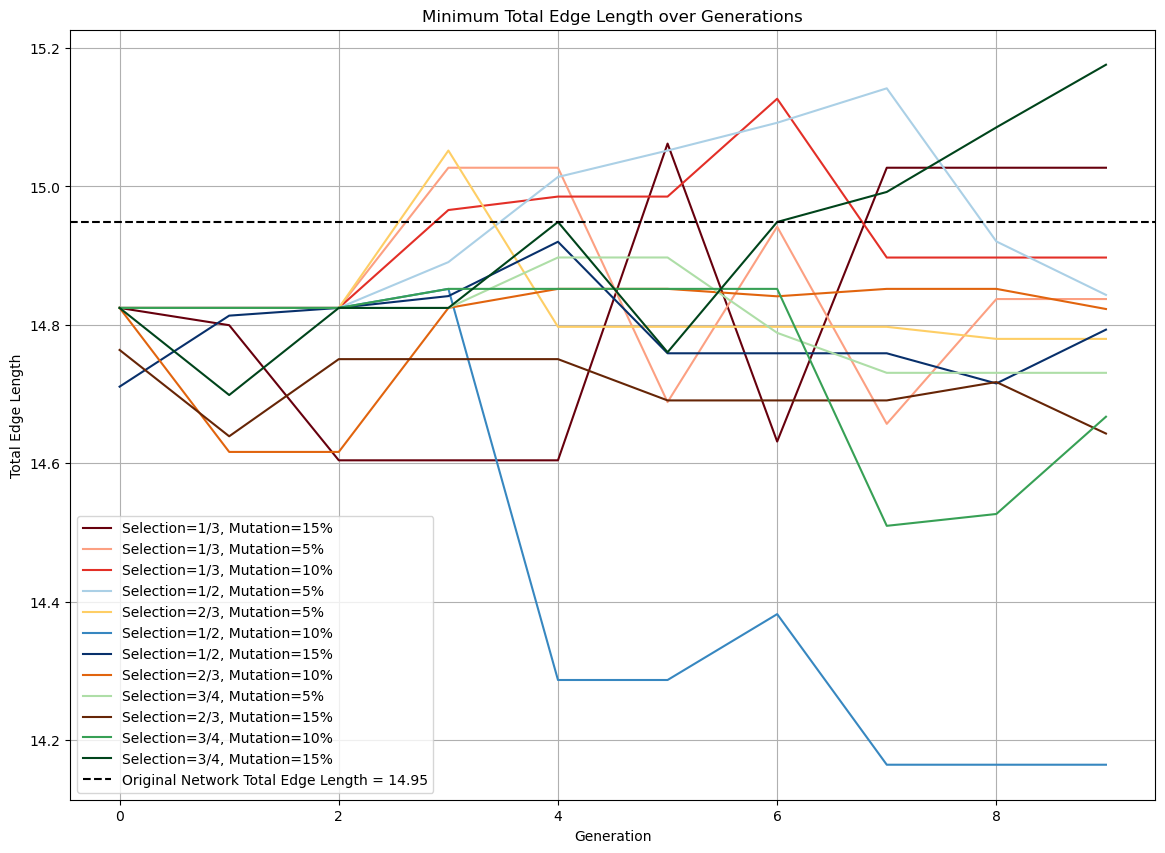

In [3]:
import numpy as np
from graph_tool.all import shortest_distance
from deap import base, creator, tools, algorithms
import python_codes.files_operators as fo
import matplotlib.pyplot as plt
from concurrent.futures import ThreadPoolExecutor, as_completed
from fractions import Fraction
from tqdm.notebook import tqdm
import matplotlib.cm as cm  # 用于色系映射
import python_codes.newga_utils as ga  # 调整后的导入路径

# 读取图和位置信息
filename1 = "ATT_US_Norm"
read_graph, read_pos = fo.read_files(f"../networks_clusters/{filename1}.net")
num_edges = read_graph.num_edges()

# 计算并添加边的欧氏距离作为权重属性
edge_weights = read_graph.new_edge_property("double")
for edge in read_graph.edges():
    source_pos = read_pos[edge.source()]
    target_pos = read_pos[edge.target()]
    euclidean_distance = np.sqrt((source_pos[0] - target_pos[0]) ** 2 + (source_pos[1] - target_pos[1]) ** 2)
    edge_weights[edge] = euclidean_distance

# 计算原始网络的最短路径和
dist_matrix = shortest_distance(read_graph, weights=edge_weights).get_2d_array(range(read_graph.num_vertices()))
original_network_value = np.sum(dist_matrix[dist_matrix != np.inf])
print(f"原始网络的最短路径和: {original_network_value}")

# 计算原始网络的边的总长度
original_total_edge_length = np.sum([edge_weights[edge] for edge in read_graph.edges()])
print(f"原始网络的边的总长度: {original_total_edge_length}")

# 创建个体和适应度
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)

# 注册工具箱
toolbox = base.Toolbox()
toolbox.register("individual", ga.init_individual, read_graph=read_graph, edge_weights=edge_weights,
                 num_edges=num_edges)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("evaluate", ga.evaluate, read_graph=read_graph, read_pos=read_pos, edge_weights=edge_weights)
toolbox.register("mate", ga.cxGraph, num_edges=num_edges)
toolbox.register("mutate", ga.mutGraph, num_edges=num_edges)
toolbox.register("select", tools.selTournament, tournsize=3)


# 主遗传算法流程，记录最小适应度值和边总长度最小值
def main(population_size, selection_ratio, mutpb, initial_population, pbar, num_generations):
    num_selected = int(population_size * selection_ratio)
    num_offspring = population_size - num_selected
    cxpb = 0.5
    pop = initial_population[:]
    hof = tools.HallOfFame(1)
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("min", np.min)
    logbook = tools.Logbook()
    logbook.header = ["gen", "min"]

    # 新增记录边总长度的数组
    edge_length_min_values = []

    for gen in range(num_generations):
        # 选择操作
        selected = toolbox.select(pop, num_selected)
        # 生成新的个体
        offspring = algorithms.varAnd(selected, toolbox, cxpb, mutpb)
        offspring = offspring[:num_offspring]
        # 更新种群
        pop[:] = selected + offspring
        # 评估适应度
        fitnesses = list(map(toolbox.evaluate, pop))
        for ind, fit in zip(pop, fitnesses):
            ind.fitness.values = fit
        # 记录和输出每一代的最优适应度值
        record = stats.compile(pop)
        logbook.record(gen=gen, **record)
        pbar.update(1)
        hof.update(pop)

        # 找到每一代中边的总长度最小的个体
        min_edge_length = float('inf')
        for ind in pop:
            graph, new_edge_weights = ga.individual_to_graph(ind, read_graph.num_vertices(), read_pos)
            total_edge_length = np.sum([new_edge_weights[edge] for edge in graph.edges()])
            if total_edge_length < min_edge_length:
                min_edge_length = total_edge_length
        edge_length_min_values.append(min_edge_length)  # 保存最小边总长度

    return logbook, hof[0].fitness.values[0], edge_length_min_values


# 参数配置
num_generations = 10
population_sizes = [300]
selection_ratios = [1 / 3, 1 / 2, 2 / 3, 3 / 4]
mutation_probs = [0.05, 0.1, 0.15]
progress_bars = {
    pop_size: tqdm(total=12 * num_generations, desc=f'Population={pop_size}', position=i, leave=True)
    for i, pop_size in enumerate(population_sizes)
}

# 执行主流程
initial_population = toolbox.population(n=population_sizes[0])
fitnesses = list(map(toolbox.evaluate, initial_population))
initial_fitness = min(fitnesses)[0]
all_logbooks = []
all_edge_lengths = []

# 执行每个种群大小的实验并绘图
for population_size in population_sizes:
    initial_population = toolbox.population(n=population_size)
    fitnesses = list(map(toolbox.evaluate, initial_population))
    initial_fitness = min(fitnesses)[0]

    with ThreadPoolExecutor(max_workers=4) as executor:
        future_to_params = {
            executor.submit(main, population_size, selection_ratio, mutpb, initial_population,
                            progress_bars[population_size], num_generations): (
                selection_ratio, mutpb)
            for selection_ratio in selection_ratios
            for mutpb in mutation_probs
        }

        for future in as_completed(future_to_params):
            selection_ratio, mutpb = future_to_params[future]
            try:
                logbook, final_fitness, edge_length_min_values = future.result()
                all_logbooks.append((logbook, selection_ratio, mutpb))
                all_edge_lengths.append((edge_length_min_values, selection_ratio, mutpb))

                print(
                    f'Completed: Pop={population_size}, Select={selection_ratio}, Mutate={mutpb} - Final Fitness={final_fitness}')

            except Exception as ex:
                print(f'Error with Pop={population_size}, Select={selection_ratio}, Mutate={mutpb}: {ex}')

# 色系映射表
color_maps = {
    Fraction(1, 3): cm.Reds,
    Fraction(1, 2): cm.Blues,
    Fraction(2, 3): cm.YlOrBr,
    Fraction(3, 4): cm.Greens
}

# 绘制适应度值随代数的变化图
plt.figure(figsize=(14, 10))
for logbook, selection_ratio, mutpb in all_logbooks:
    min_fitness_values = logbook.select("min")
    generations = list(range(1, len(min_fitness_values) + 1))
    fitness_values = [initial_fitness] + min_fitness_values
    generations = [0] + generations

    # 根据选择比例获取色系，根据变异概率调整颜色深度
    color_map = color_maps[Fraction(selection_ratio).limit_denominator()]
    color_intensity = (mutation_probs.index(mutpb) + 1) / len(mutation_probs)
    color = color_map(color_intensity)

    plt.plot(generations, fitness_values,
             label=f'Selection={Fraction(selection_ratio).limit_denominator()}, Mutation={int(mutpb * 100)}%',
             color=color)

# 在图表上添加原始网络的最短路径和
plt.axhline(y=original_network_value, color='k', linestyle='--',
            label=f'Original Network Shortest Path Sum = {original_network_value:.2f}')
plt.title("Fitness Value over Generations")
plt.xlabel("Generation")
plt.ylabel("Fitness Value")
plt.legend()
plt.grid(True)
plt.savefig(f"./output2/{filename1}_fitness_{num_generations}gens.png")  # 保存图表
plt.show()

# 新增：绘制每代最小边总长度变化图
plt.figure(figsize=(14, 10))
for edge_length_min_values, selection_ratio, mutpb in all_edge_lengths:
    generations = list(range(num_generations))

    # 根据选择比例获取色系，根据变异概率调整颜色深度
    color_map = color_maps[Fraction(selection_ratio).limit_denominator()]
    color_intensity = (mutation_probs.index(mutpb) + 1) / len(mutation_probs)
    color = color_map(color_intensity)

    plt.plot(generations, edge_length_min_values,
             label=f'Selection={Fraction(selection_ratio).limit_denominator()}, Mutation={int(mutpb * 100)}%',
             color=color)

# 在图表上添加原始网络的总边长度
plt.axhline(y=original_total_edge_length, color='k', linestyle='--',
            label=f'Original Network Total Edge Length = {original_total_edge_length:.2f}')
plt.title("Minimum Total Edge Length over Generations")
plt.xlabel("Generation")
plt.ylabel("Total Edge Length")
plt.legend()
plt.grid(True)
plt.savefig(f"./output2/{filename1}_total_edge_length_{num_generations}gens.png")  # 保存图表
plt.show()


原始网络的最短路径和: 383.05722914981766
原始网络的边的总长度: 14.948198914997414


Population=300:   0%|          | 0/120 [00:00<?, ?it/s]

Completed: Pop=300, Select=0.3333333333333333, Mutate=0.1 - Final Fitness=366.3590283734302
Completed: Pop=300, Select=0.3333333333333333, Mutate=0.15 - Final Fitness=364.44307356776494
Completed: Pop=300, Select=0.3333333333333333, Mutate=0.05 - Final Fitness=364.6759517987595
Completed: Pop=300, Select=0.5, Mutate=0.05 - Final Fitness=356.0274539608706
Completed: Pop=300, Select=0.5, Mutate=0.1 - Final Fitness=356.7646394413736
Completed: Pop=300, Select=0.5, Mutate=0.15 - Final Fitness=363.7012419928352
Completed: Pop=300, Select=0.6666666666666666, Mutate=0.05 - Final Fitness=358.00477247024514
Completed: Pop=300, Select=0.6666666666666666, Mutate=0.1 - Final Fitness=363.9406450161927
Completed: Pop=300, Select=0.6666666666666666, Mutate=0.15 - Final Fitness=360.4997018822929
Completed: Pop=300, Select=0.75, Mutate=0.05 - Final Fitness=361.68730025620897
Completed: Pop=300, Select=0.75, Mutate=0.1 - Final Fitness=359.4101818495168
Completed: Pop=300, Select=0.75, Mutate=0.15 - Fina

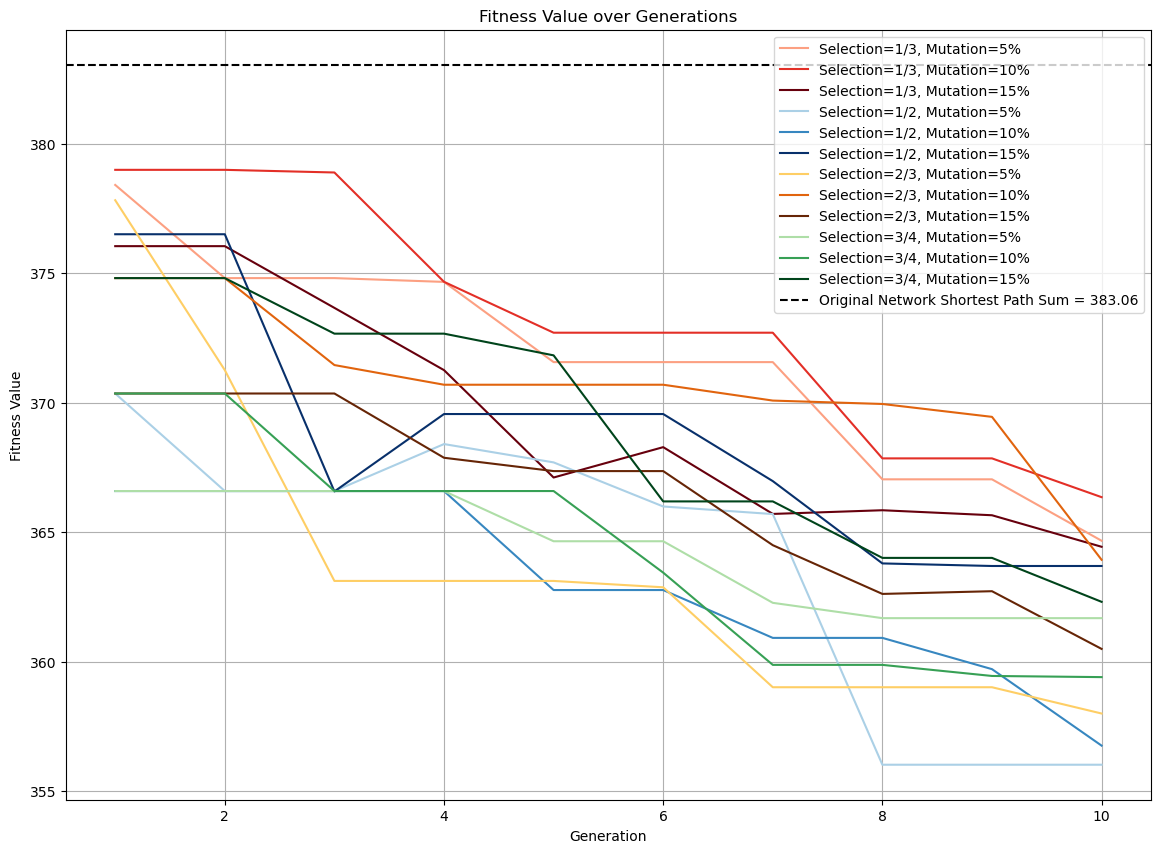

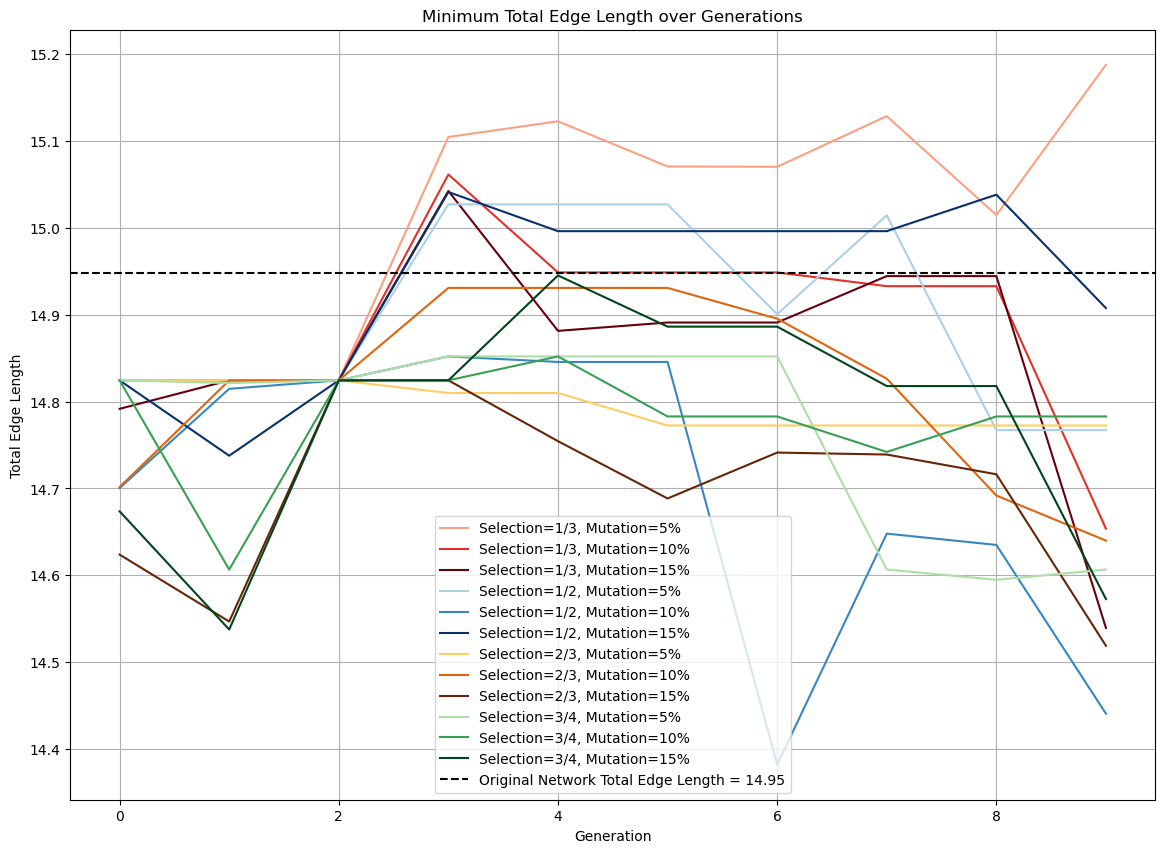

In [4]:
import numpy as np
from graph_tool.all import shortest_distance
from deap import base, creator, tools, algorithms
import python_codes.files_operators as fo
import matplotlib.pyplot as plt
from concurrent.futures import ThreadPoolExecutor, as_completed
from fractions import Fraction
from tqdm.notebook import tqdm
import matplotlib.cm as cm  # 用于色系映射
import python_codes.newga_utils as ga  # 调整后的导入路径

# 读取图和位置信息
filename1 = "ATT_US_Norm"
read_graph, read_pos = fo.read_files(f"../networks_clusters/{filename1}.net")
num_edges = read_graph.num_edges()

# 计算并添加边的欧氏距离作为权重属性
edge_weights = read_graph.new_edge_property("double")
for edge in read_graph.edges():
    source_pos = read_pos[edge.source()]
    target_pos = read_pos[edge.target()]
    euclidean_distance = np.sqrt((source_pos[0] - target_pos[0]) ** 2 + (source_pos[1] - target_pos[1]) ** 2)
    edge_weights[edge] = euclidean_distance

# 计算原始网络的最短路径和
dist_matrix = shortest_distance(read_graph, weights=edge_weights).get_2d_array(range(read_graph.num_vertices()))
original_network_value = np.sum(dist_matrix[dist_matrix != np.inf])
print(f"原始网络的最短路径和: {original_network_value}")

# 计算原始网络的边的总长度
original_total_edge_length = np.sum([edge_weights[edge] for edge in read_graph.edges()])
print(f"原始网络的边的总长度: {original_total_edge_length}")

# 创建个体和适应度
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)

# 注册工具箱
toolbox = base.Toolbox()
toolbox.register("individual", ga.init_individual, read_graph=read_graph, edge_weights=edge_weights,
                 num_edges=num_edges)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("evaluate", ga.evaluate, read_graph=read_graph, read_pos=read_pos, edge_weights=edge_weights)
toolbox.register("mate", ga.cxGraph, num_edges=num_edges)
toolbox.register("mutate", ga.mutGraph, num_edges=num_edges)
toolbox.register("select", tools.selTournament, tournsize=3)


# 主遗传算法流程，记录最小适应度值和边总长度最小值
def main(population_size, selection_ratio, mutpb, initial_population, pbar, num_generations):
    num_selected = int(population_size * selection_ratio)
    num_offspring = population_size - num_selected
    cxpb = 0.5
    pop = initial_population[:]
    hof = tools.HallOfFame(1)
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("min", np.min)
    logbook = tools.Logbook()
    logbook.header = ["gen", "min"]

    # 新增记录边总长度的数组
    edge_length_min_values = []

    for gen in range(num_generations):
        # 选择操作
        selected = toolbox.select(pop, num_selected)
        # 生成新的个体
        offspring = algorithms.varAnd(selected, toolbox, cxpb, mutpb)
        offspring = offspring[:num_offspring]
        # 更新种群
        pop[:] = selected + offspring
        # 评估适应度
        fitnesses = list(map(toolbox.evaluate, pop))
        for ind, fit in zip(pop, fitnesses):
            ind.fitness.values = fit
        # 记录和输出每一代的最优适应度值
        record = stats.compile(pop)
        logbook.record(gen=gen, **record)
        pbar.update(1)
        hof.update(pop)

        # 找到每一代中边的总长度最小的个体
        min_edge_length = float('inf')
        for ind in pop:
            graph, new_edge_weights = ga.individual_to_graph(ind, read_graph.num_vertices(), read_pos)
            total_edge_length = np.sum([new_edge_weights[edge] for edge in graph.edges()])
            if total_edge_length < min_edge_length:
                min_edge_length = total_edge_length
        edge_length_min_values.append(min_edge_length)  # 保存最小边总长度

    return logbook, hof[0].fitness.values[0], edge_length_min_values


# 参数配置
num_generations = 10
population_sizes = [300]
selection_ratios = [1 / 3, 1 / 2, 2 / 3, 3 / 4]
mutation_probs = [0.05, 0.1, 0.15]
progress_bars = {
    pop_size: tqdm(total=12 * num_generations, desc=f'Population={pop_size}', position=i, leave=True)
    for i, pop_size in enumerate(population_sizes)
}

# 执行主流程
initial_population = toolbox.population(n=population_sizes[0])
fitnesses = list(map(toolbox.evaluate, initial_population))
initial_fitness = min(fitnesses)[0]
all_logbooks = []
all_edge_lengths = []

# 执行每个种群大小的实验并绘图
for population_size in population_sizes:
    initial_population = toolbox.population(n=population_size)
    fitnesses = list(map(toolbox.evaluate, initial_population))
    initial_fitness = min(fitnesses)[0]

    with ThreadPoolExecutor(max_workers=4) as executor:
        future_to_params = {
            executor.submit(main, population_size, selection_ratio, mutpb, initial_population,
                            progress_bars[population_size], num_generations): (
                selection_ratio, mutpb)
            for selection_ratio in selection_ratios
            for mutpb in mutation_probs
        }

        for future in as_completed(future_to_params):
            selection_ratio, mutpb = future_to_params[future]
            try:
                logbook, final_fitness, edge_length_min_values = future.result()
                all_logbooks.append((logbook, selection_ratio, mutpb))
                all_edge_lengths.append((edge_length_min_values, selection_ratio, mutpb))

                print(
                    f'Completed: Pop={population_size}, Select={selection_ratio}, Mutate={mutpb} - Final Fitness={final_fitness}')

            except Exception as ex:
                print(f'Error with Pop={population_size}, Select={selection_ratio}, Mutate={mutpb}: {ex}')

# 色系映射表
color_maps = {
    Fraction(1, 3): cm.Reds,
    Fraction(1, 2): cm.Blues,
    Fraction(2, 3): cm.YlOrBr,
    Fraction(3, 4): cm.Greens
}

# 对记录进行排序以确保顺序一致
all_logbooks.sort(key=lambda x: (x[1], x[2]))  # 按选择比例和变异概率排序
all_edge_lengths.sort(key=lambda x: (x[1], x[2]))

# 绘制适应度值随代数的变化图
plt.figure(figsize=(14, 10))
for logbook, selection_ratio, mutpb in all_logbooks:
    min_fitness_values = logbook.select("min")
    generations = list(range(1, len(min_fitness_values) + 1))
    fitness_values = [initial_fitness] + min_fitness_values
    generations = [0] + generations

    # 根据选择比例获取色系，根据变异概率调整颜色深度
    color_map = color_maps[Fraction(selection_ratio).limit_denominator()]
    color_intensity = (mutation_probs.index(mutpb) + 1) / len(mutation_probs)
    color = color_map(color_intensity)

    plt.plot(generations, fitness_values,
             label=f'Selection={Fraction(selection_ratio).limit_denominator()}, Mutation={int(mutpb * 100)}%',
             color=color)

# 在图表上添加原始网络的最短路径和
plt.axhline(y=original_network_value, color='k', linestyle='--',
            label=f'Original Network Shortest Path Sum = {original_network_value:.2f}')
plt.title("Fitness Value over Generations")
plt.xlabel("Generation")
plt.ylabel("Fitness Value")
plt.legend()
plt.grid(True)
plt.savefig(f"./output2/{filename1}_fitness_{num_generations}gens.png")  # 保存图表
plt.show()

# 绘制每代最小边总长度变化图
plt.figure(figsize=(14, 10))
for edge_length_min_values, selection_ratio, mutpb in all_edge_lengths:
    generations = list(range(num_generations))

    # 根据选择比例获取色系，根据变异概率调整颜色深度
    color_map = color_maps[Fraction(selection_ratio).limit_denominator()]
    color_intensity = (mutation_probs.index(mutpb) + 1) / len(mutation_probs)
    color = color_map(color_intensity)

    plt.plot(generations, edge_length_min_values,
             label=f'Selection={Fraction(selection_ratio).limit_denominator()}, Mutation={int(mutpb * 100)}%',
             color=color)

# 在图表上添加原始网络的总边长度
plt.axhline(y=original_total_edge_length, color='k', linestyle='--',
            label=f'Original Network Total Edge Length = {original_total_edge_length:.2f}')
plt.title("Minimum Total Edge Length over Generations")
plt.xlabel("Generation")
plt.ylabel("Total Edge Length")
plt.legend()
plt.grid(True)
plt.savefig(f"./output2/{filename1}_total_edge_length_{num_generations}gens.png")  # 保存图表
plt.show()


原始网络的最短路径和: 383.05722914981766
原始网络的边的总长度: 14.948198914997414


Population=300:   0%|          | 0/60 [00:00<?, ?it/s]

Completed: Pop=300, Select=0.3333333333333333, Mutate=0.05 - Final Fitness=365.0775348001117
Completed: Pop=300, Select=0.3333333333333333, Mutate=0.1 - Final Fitness=372.1428410377223
Completed: Pop=300, Select=0.3333333333333333, Mutate=0.15 - Final Fitness=372.39789739837227
Completed: Pop=300, Select=0.5, Mutate=0.05 - Final Fitness=365.96187057227127
Completed: Pop=300, Select=0.5, Mutate=0.1 - Final Fitness=365.34661020742965
Completed: Pop=300, Select=0.5, Mutate=0.15 - Final Fitness=359.03879064140676
Completed: Pop=300, Select=0.6666666666666666, Mutate=0.05 - Final Fitness=371.26422346502966
Completed: Pop=300, Select=0.6666666666666666, Mutate=0.1 - Final Fitness=361.75839030215684
Completed: Pop=300, Select=0.6666666666666666, Mutate=0.15 - Final Fitness=364.8614136954337
Completed: Pop=300, Select=0.75, Mutate=0.1 - Final Fitness=371.26422346502966
Completed: Pop=300, Select=0.75, Mutate=0.05 - Final Fitness=371.74425800025654
Completed: Pop=300, Select=0.75, Mutate=0.15 -

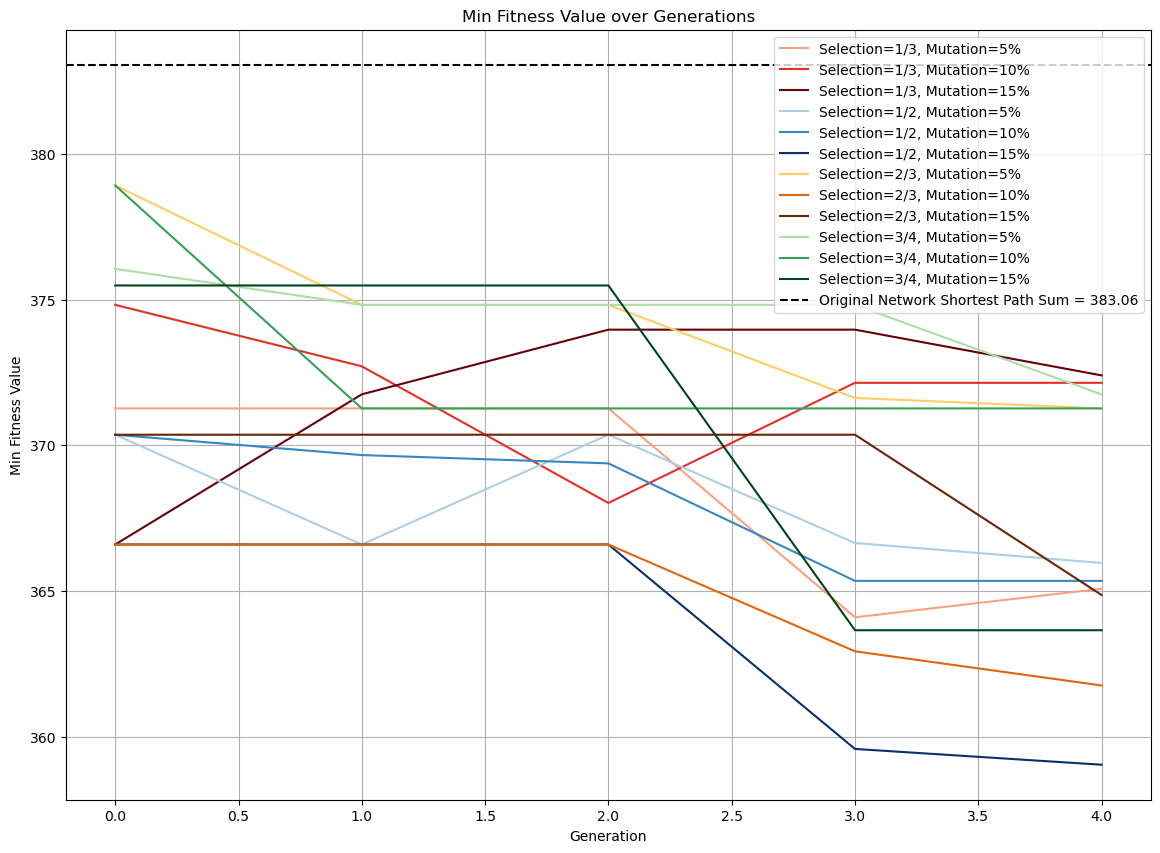

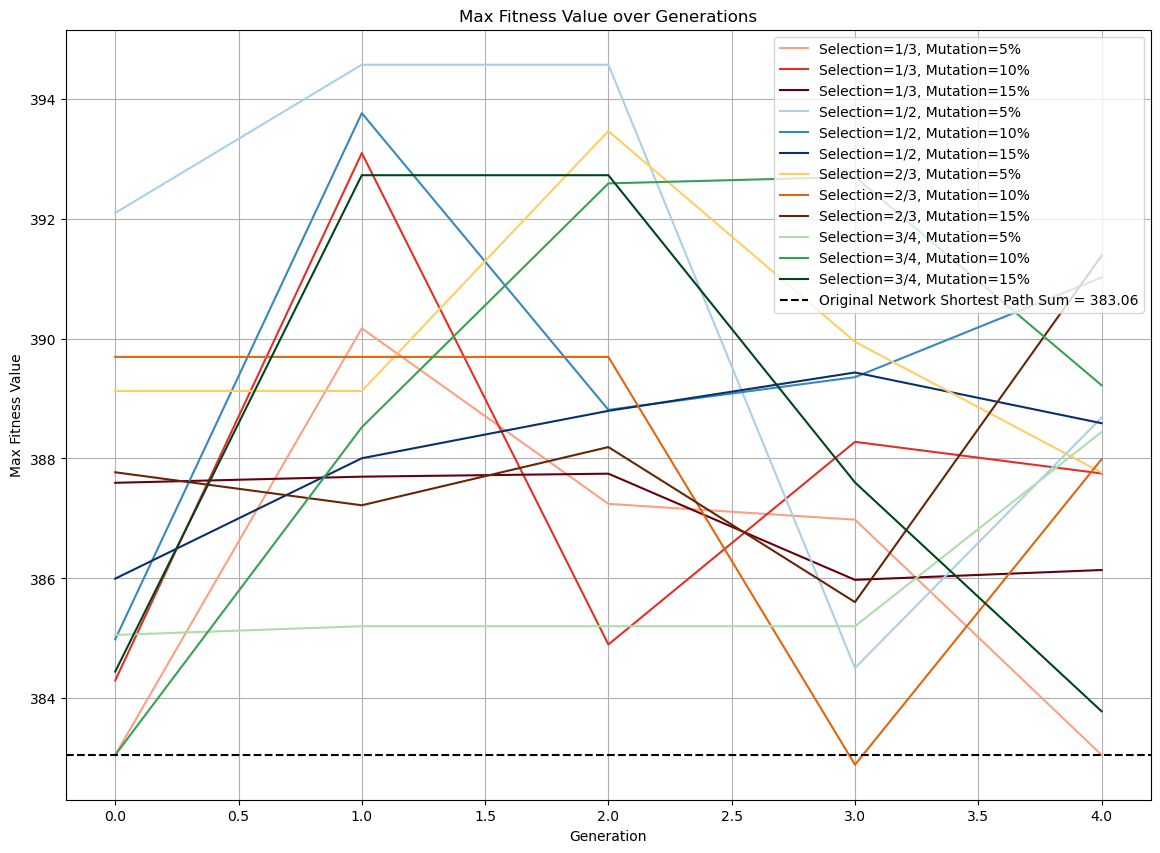

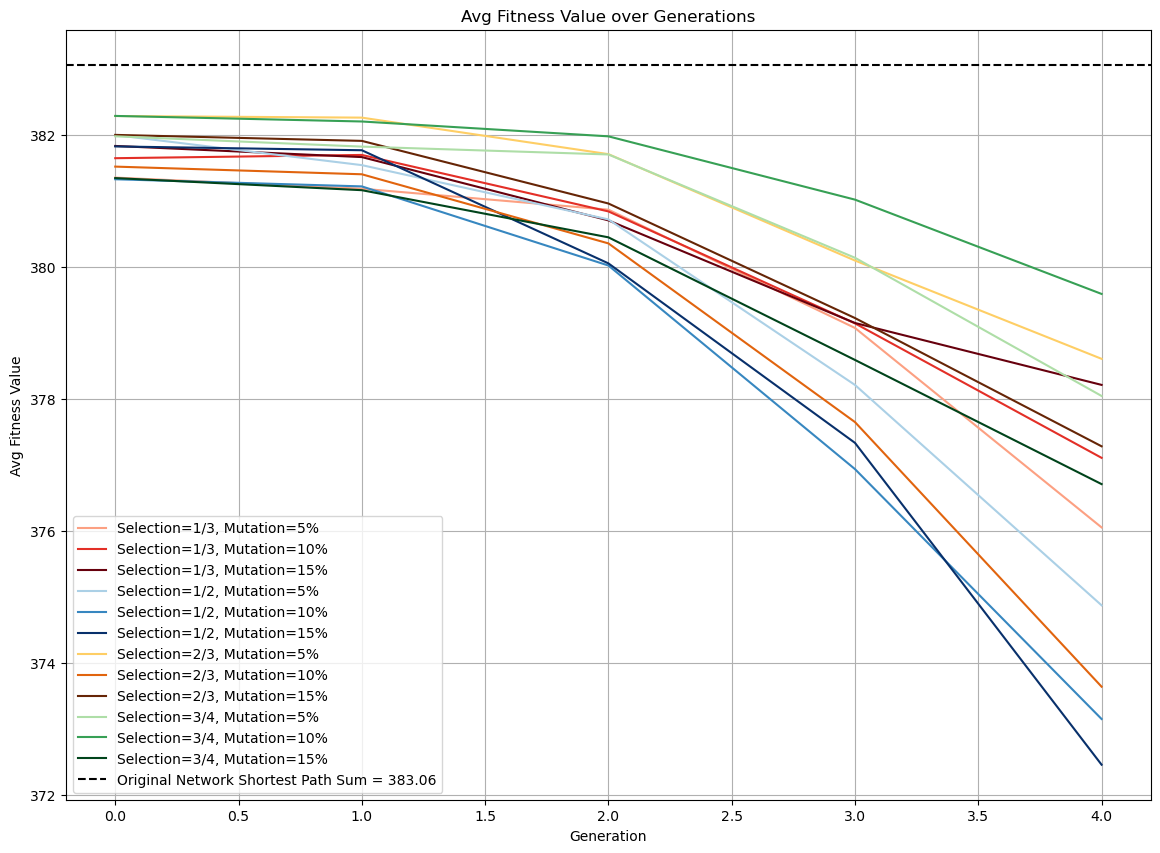

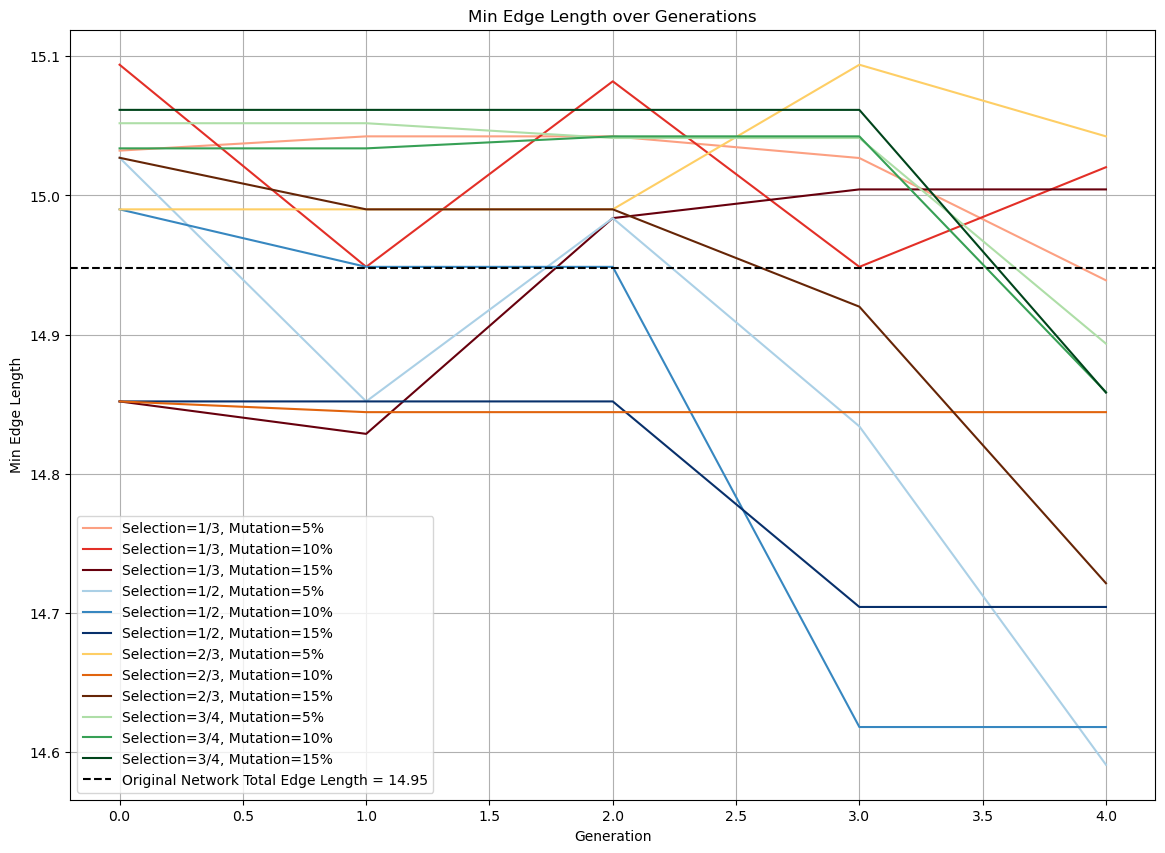

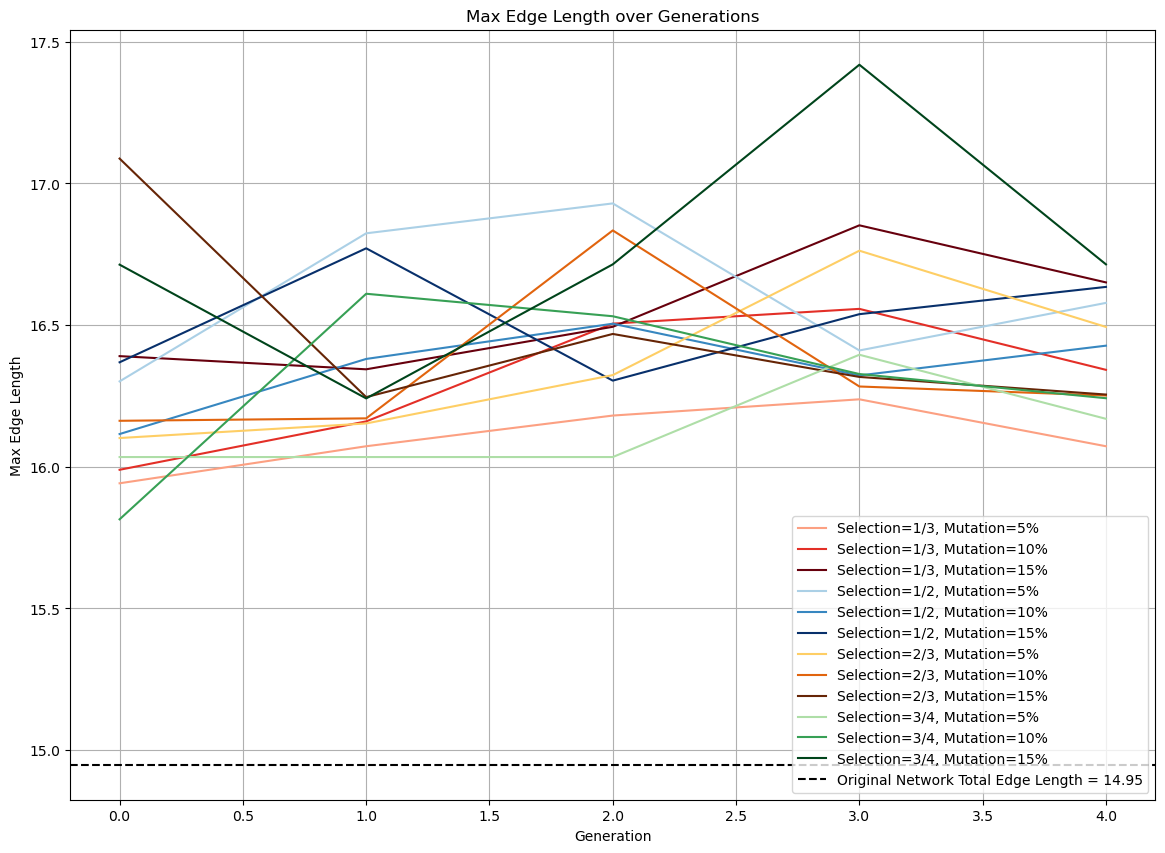

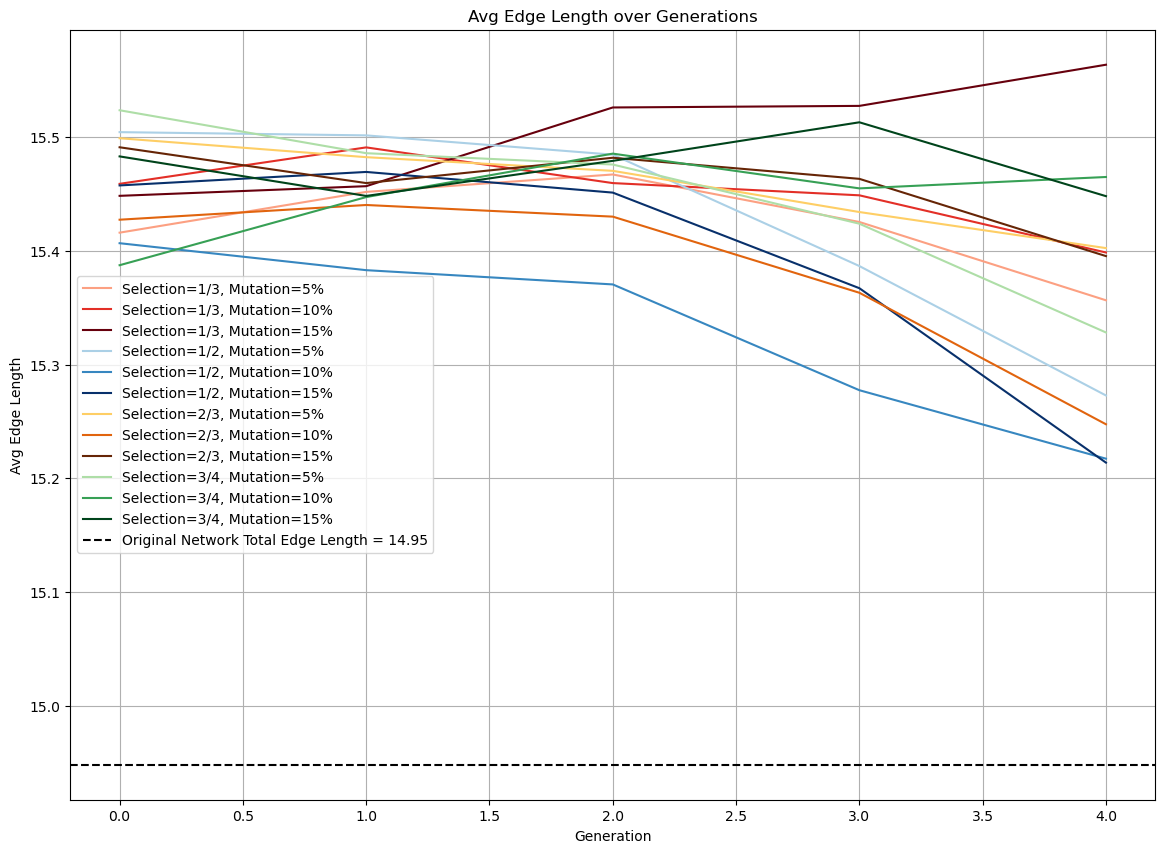

In [5]:
import numpy as np
from graph_tool.all import shortest_distance
from deap import base, creator, tools, algorithms
import python_codes.files_operators as fo
import matplotlib.pyplot as plt
from concurrent.futures import ThreadPoolExecutor, as_completed
from fractions import Fraction
from tqdm.notebook import tqdm
import matplotlib.cm as cm  # 用于色系映射
import python_codes.newga_utils as ga  # 调整后的导入路径

# 读取图和位置信息
filename1 = "ATT_US_Norm"
read_graph, read_pos = fo.read_files(f"../networks_clusters/{filename1}.net")
num_edges = read_graph.num_edges()

# 计算并添加边的欧氏距离作为权重属性
edge_weights = read_graph.new_edge_property("double")
for edge in read_graph.edges():
    source_pos = read_pos[edge.source()]
    target_pos = read_pos[edge.target()]
    euclidean_distance = np.sqrt((source_pos[0] - target_pos[0]) ** 2 + (source_pos[1] - target_pos[1]) ** 2)
    edge_weights[edge] = euclidean_distance

# 计算原始网络的最短路径和
dist_matrix = shortest_distance(read_graph, weights=edge_weights).get_2d_array(range(read_graph.num_vertices()))
original_network_value = np.sum(dist_matrix[dist_matrix != np.inf])
print(f"原始网络的最短路径和: {original_network_value}")

# 计算原始网络的边的总长度
original_total_edge_length = np.sum([edge_weights[edge] for edge in read_graph.edges()])
print(f"原始网络的边的总长度: {original_total_edge_length}")

# 创建个体和适应度
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)

# 注册工具箱
toolbox = base.Toolbox()
toolbox.register("individual", ga.init_individual, read_graph=read_graph, edge_weights=edge_weights,
                 num_edges=num_edges)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("evaluate", ga.evaluate, read_graph=read_graph, read_pos=read_pos, edge_weights=edge_weights)
toolbox.register("mate", ga.cxGraph, num_edges=num_edges)
toolbox.register("mutate", ga.mutGraph, num_edges=num_edges)
toolbox.register("select", tools.selTournament, tournsize=3)


# 主遗传算法流程，记录最小、最大和平均适应度值及边总长度
def main(population_size, selection_ratio, mutpb, initial_population, pbar, num_generations):
    num_selected = int(population_size * selection_ratio)
    num_offspring = population_size - num_selected
    cxpb = 0.5
    pop = initial_population[:]
    hof = tools.HallOfFame(1)
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("min", np.min)
    logbook = tools.Logbook()
    logbook.header = ["gen", "min", "max", "avg"]

    # 新增记录边总长度的数组
    edge_length_min_values = []
    edge_length_max_values = []
    edge_length_avg_values = []

    for gen in range(num_generations):
        # 选择操作
        selected = toolbox.select(pop, num_selected)
        # 生成新的个体
        offspring = algorithms.varAnd(selected, toolbox, cxpb, mutpb)
        offspring = offspring[:num_offspring]
        # 更新种群
        pop[:] = selected + offspring
        # 评估适应度
        fitnesses = list(map(toolbox.evaluate, pop))
        for ind, fit in zip(pop, fitnesses):
            ind.fitness.values = fit

        # 剔除适应度为无限大的个体
        valid_individuals = [ind for ind in pop if ind.fitness.values[0] != float('inf')]

        # 计算适应度值的最小、最大和平均值
        if valid_individuals:
            fitness_values = [ind.fitness.values[0] for ind in valid_individuals]
            min_fitness = np.min(fitness_values)
            max_fitness = np.max(fitness_values)
            avg_fitness = np.mean(fitness_values)
        else:
            min_fitness = max_fitness = avg_fitness = float('inf')

        # 记录和输出每一代的适应度统计值
        logbook.record(gen=gen, min=min_fitness, max=max_fitness, avg=avg_fitness)
        pbar.update(1)
        hof.update(pop)

        # 计算每一代中边的总长度最小、最大和平均值
        edge_lengths = []
        for ind in valid_individuals:
            graph, new_edge_weights = ga.individual_to_graph(ind, read_graph.num_vertices(), read_pos)
            total_edge_length = np.sum([new_edge_weights[edge] for edge in graph.edges()])
            edge_lengths.append(total_edge_length)

        if edge_lengths:
            edge_length_min_values.append(np.min(edge_lengths))
            edge_length_max_values.append(np.max(edge_lengths))
            edge_length_avg_values.append(np.mean(edge_lengths))
        else:
            edge_length_min_values.append(float('inf'))
            edge_length_max_values.append(float('inf'))
            edge_length_avg_values.append(float('inf'))

    return logbook, edge_length_min_values, edge_length_max_values, edge_length_avg_values


# 参数配置
num_generations = 5
population_sizes = [300]
selection_ratios = [1 / 3, 1 / 2, 2 / 3, 3 / 4]
mutation_probs = [0.05, 0.1, 0.15]
progress_bars = {
    pop_size: tqdm(total=12 * num_generations, desc=f'Population={pop_size}', position=i, leave=True)
    for i, pop_size in enumerate(population_sizes)
}

# 执行主流程
initial_population = toolbox.population(n=population_sizes[0])
fitnesses = list(map(toolbox.evaluate, initial_population))
initial_fitness = min(fitnesses)[0]
all_logbooks = []
all_edge_lengths = []

# 执行每个种群大小的实验并绘图
for population_size in population_sizes:
    initial_population = toolbox.population(n=population_size)
    fitnesses = list(map(toolbox.evaluate, initial_population))
    initial_fitness = min(fitnesses)[0]

    with ThreadPoolExecutor(max_workers=4) as executor:
        future_to_params = {
            executor.submit(main, population_size, selection_ratio, mutpb, initial_population,
                            progress_bars[population_size], num_generations): (
                selection_ratio, mutpb)
            for selection_ratio in selection_ratios
            for mutpb in mutation_probs
        }

        for future in as_completed(future_to_params):
            selection_ratio, mutpb = future_to_params[future]
            try:
                logbook, edge_length_min_values, edge_length_max_values, edge_length_avg_values = future.result()
                all_logbooks.append((logbook, selection_ratio, mutpb))
                all_edge_lengths.append(
                    (edge_length_min_values, edge_length_max_values, edge_length_avg_values, selection_ratio, mutpb))

                print(
                    f'Completed: Pop={population_size}, Select={selection_ratio}, Mutate={mutpb} - Final Fitness={logbook[-1]["min"]}')

            except Exception as ex:
                print(f'Error with Pop={population_size}, Select={selection_ratio}, Mutate={mutpb}: {ex}')

# 色系映射表
color_maps = {
    Fraction(1, 3): cm.Reds,
    Fraction(1, 2): cm.Blues,
    Fraction(2, 3): cm.YlOrBr,
    Fraction(3, 4): cm.Greens
}

# 对记录进行排序以确保顺序一致
all_logbooks.sort(key=lambda x: (x[1], x[2]))  # 按选择比例和变异概率排序
all_edge_lengths.sort(key=lambda x: (x[3], x[4]))

# 绘制适应度值的最小、最大和平均值图
for metric in ["min", "max", "avg"]:
    plt.figure(figsize=(14, 10))
    for logbook, selection_ratio, mutpb in all_logbooks:
        values = logbook.select(metric)
        generations = list(range(len(values)))
        color_map = color_maps[Fraction(selection_ratio).limit_denominator()]
        color_intensity = (mutation_probs.index(mutpb) + 1) / len(mutation_probs)
        color = color_map(color_intensity)

        plt.plot(generations, values, linestyle="-", color=color,
                 label=f'Selection={Fraction(selection_ratio).limit_denominator()}, Mutation={int(mutpb * 100)}%')

    plt.axhline(y=original_network_value, color='k', linestyle='--',
                label=f'Original Network Shortest Path Sum = {original_network_value:.2f}')
    plt.title(f"{metric.capitalize()} Fitness Value over Generations")
    plt.xlabel("Generation")
    plt.ylabel(f"{metric.capitalize()} Fitness Value")
    plt.legend()
    plt.grid(True)
    plt.savefig(f"./output2/{filename1}_{metric}_fitness_{num_generations}gens.png")
    plt.show()

# 绘制边总长度的最小、最大和平均值图
for metric, values in zip(["min", "max", "avg"], [0, 1, 2]):
    plt.figure(figsize=(14, 10))
    for edge_length_min_values, edge_length_max_values, edge_length_avg_values, selection_ratio, mutpb in all_edge_lengths:
        generations = list(range(num_generations))
        color_map = color_maps[Fraction(selection_ratio).limit_denominator()]
        color_intensity = (mutation_probs.index(mutpb) + 1) / len(mutation_probs)
        color = color_map(color_intensity)

        plt.plot(generations, [edge_length_min_values, edge_length_max_values, edge_length_avg_values][values],
                 linestyle="-", color=color,
                 label=f'Selection={Fraction(selection_ratio).limit_denominator()}, Mutation={int(mutpb * 100)}%')

    plt.axhline(y=original_total_edge_length, color='k', linestyle='--',
                label=f'Original Network Total Edge Length = {original_total_edge_length:.2f}')
    plt.title(f"{metric.capitalize()} Edge Length over Generations")
    plt.xlabel("Generation")
    plt.ylabel(f"{metric.capitalize()} Edge Length")
    plt.legend()
    plt.grid(True)
    plt.savefig(f"./output2/{filename1}_{metric}_edge_length_{num_generations}gens.png")
    plt.show()


原始网络的最短路径和: 383.05722914981766
原始网络的边的总长度: 14.948198914997414


Population=300:   0%|          | 0/120 [00:00<?, ?it/s]

Completed: Pop=300, Select=0.3333333333333333, Mutate=0.1 - Final Fitness=363.88017907293937
Completed: Pop=300, Select=0.3333333333333333, Mutate=0.05 - Final Fitness=364.5850772854509
Completed: Pop=300, Select=0.3333333333333333, Mutate=0.15 - Final Fitness=355.3163527861584
Completed: Pop=300, Select=0.5, Mutate=0.05 - Final Fitness=356.0162511221589
Completed: Pop=300, Select=0.5, Mutate=0.1 - Final Fitness=362.5901434209035
Completed: Pop=300, Select=0.5, Mutate=0.15 - Final Fitness=358.62107667523634
Completed: Pop=300, Select=0.6666666666666666, Mutate=0.05 - Final Fitness=364.58738543572014
Completed: Pop=300, Select=0.6666666666666666, Mutate=0.1 - Final Fitness=358.20107990298254
Completed: Pop=300, Select=0.6666666666666666, Mutate=0.15 - Final Fitness=361.89475220172915
Completed: Pop=300, Select=0.75, Mutate=0.05 - Final Fitness=363.6228183971725
Completed: Pop=300, Select=0.75, Mutate=0.1 - Final Fitness=370.5494681736651
Completed: Pop=300, Select=0.75, Mutate=0.15 - Fi

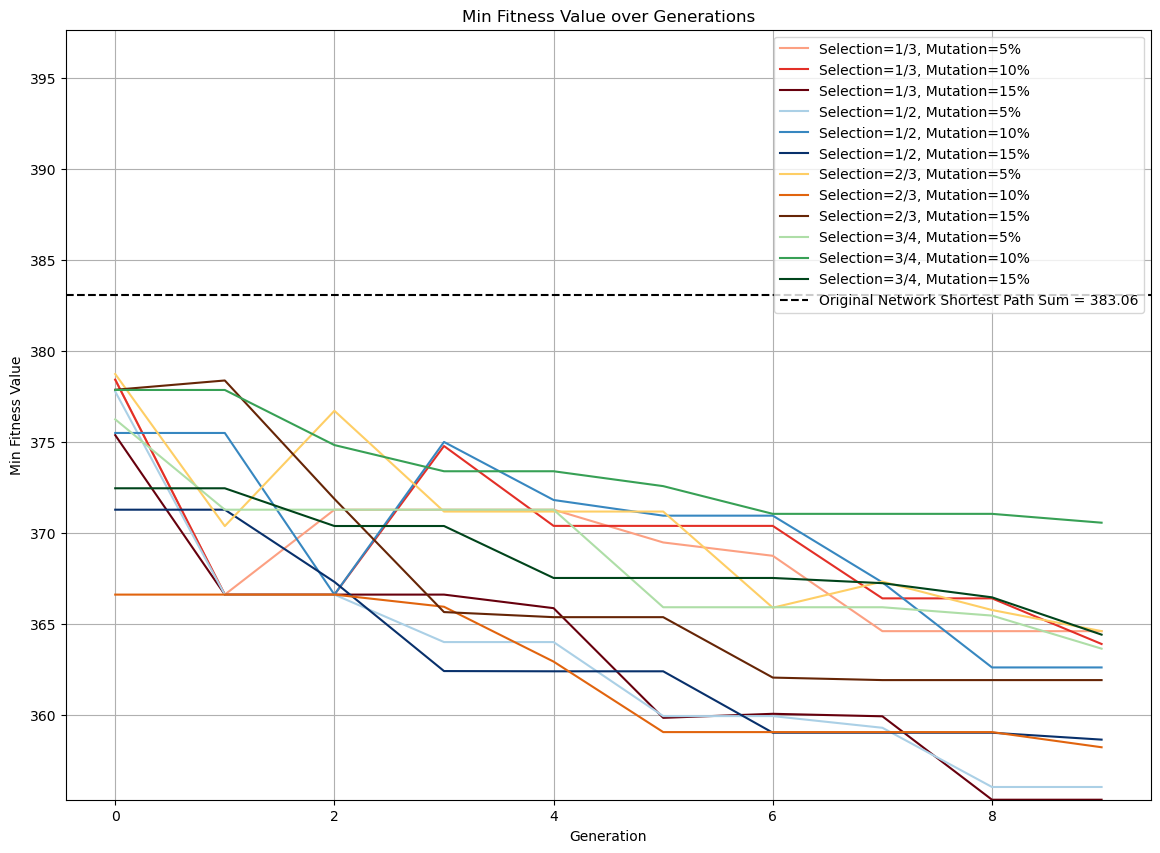

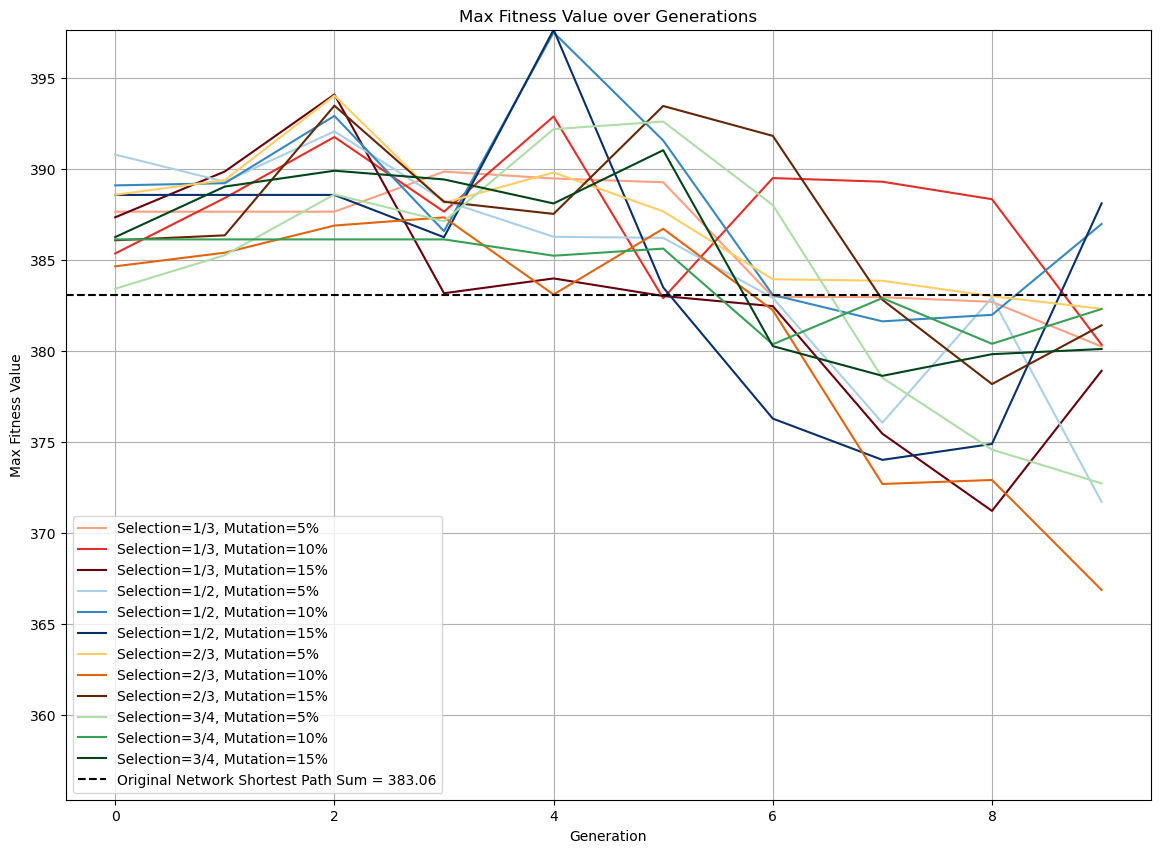

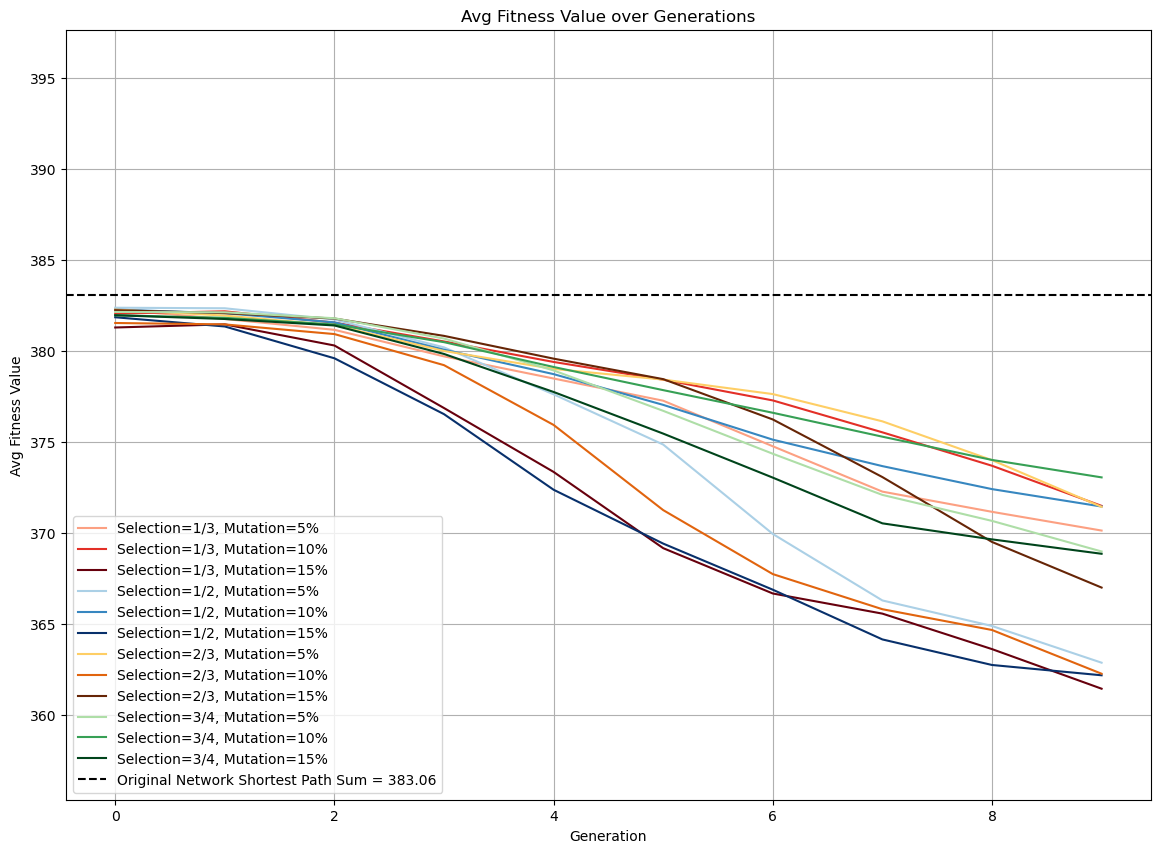

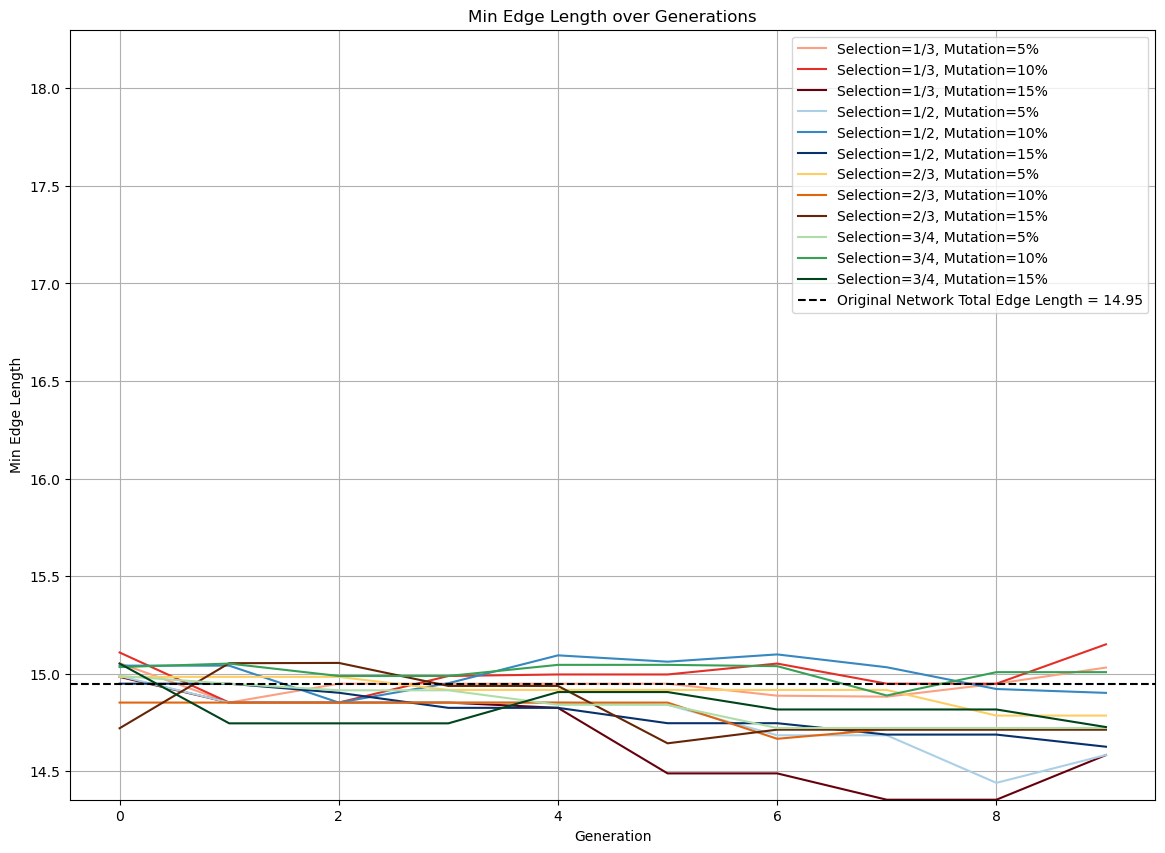

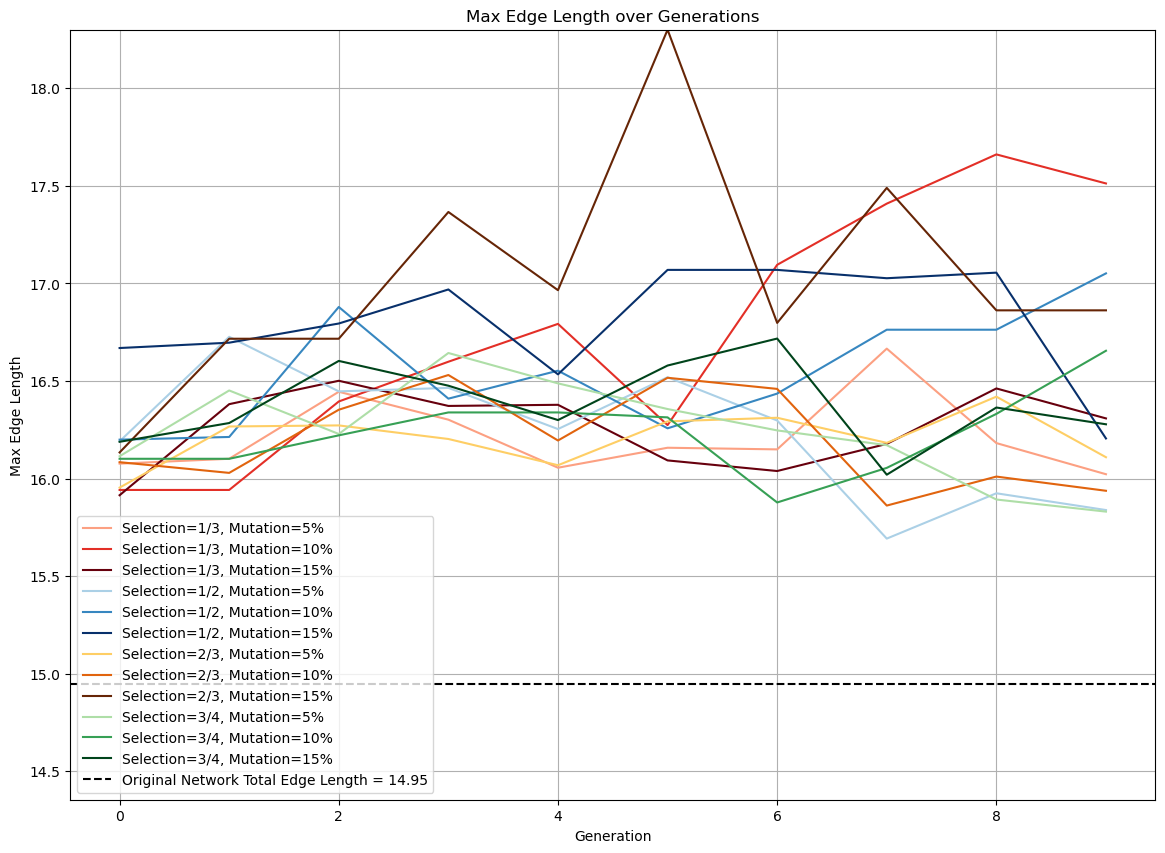

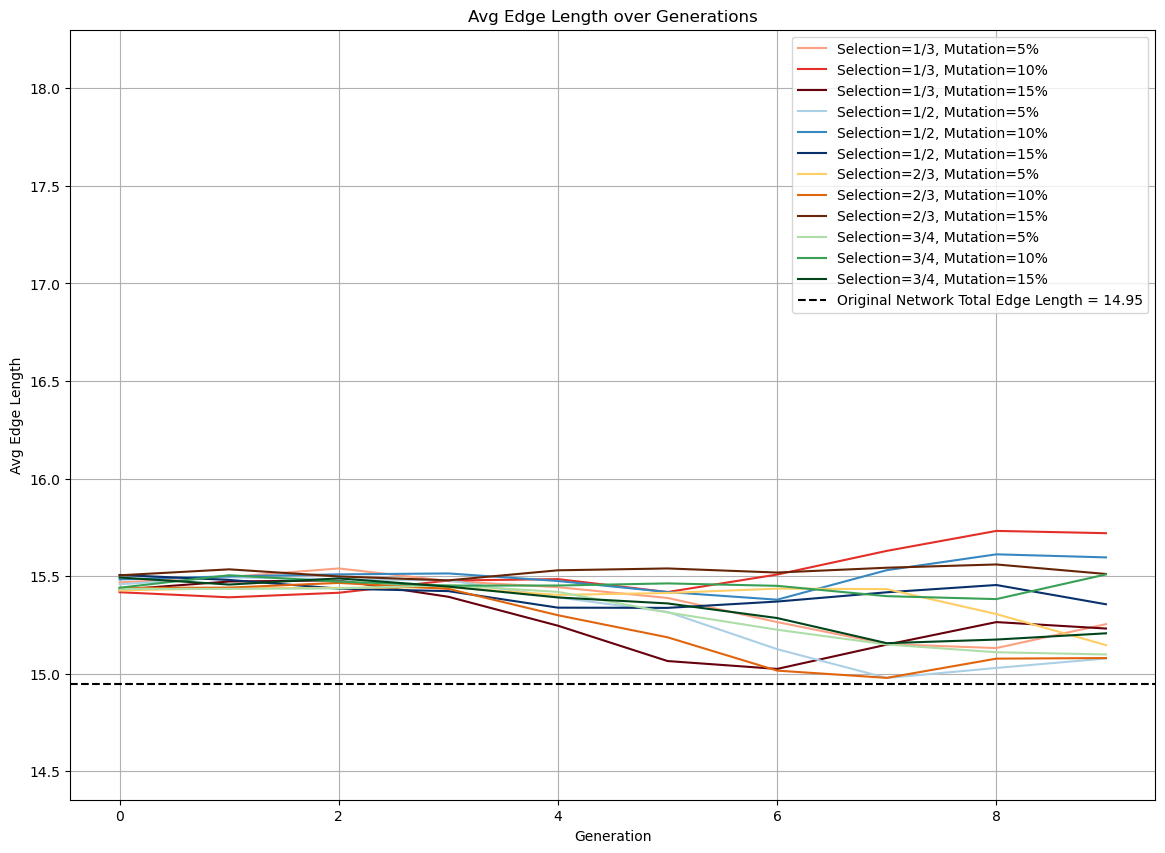

In [6]:
import numpy as np
from graph_tool.all import shortest_distance
from deap import base, creator, tools, algorithms
import python_codes.files_operators as fo
import matplotlib.pyplot as plt
from concurrent.futures import ThreadPoolExecutor, as_completed
from fractions import Fraction
from tqdm.notebook import tqdm
import matplotlib.cm as cm  # 用于色系映射
import python_codes.newga_utils as ga  # 调整后的导入路径

# 读取图和位置信息
filename1 = "ATT_US_Norm"
read_graph, read_pos = fo.read_files(f"../networks_clusters/{filename1}.net")
num_edges = read_graph.num_edges()

# 计算并添加边的欧氏距离作为权重属性
edge_weights = read_graph.new_edge_property("double")
for edge in read_graph.edges():
    source_pos = read_pos[edge.source()]
    target_pos = read_pos[edge.target()]
    euclidean_distance = np.sqrt((source_pos[0] - target_pos[0]) ** 2 + (source_pos[1] - target_pos[1]) ** 2)
    edge_weights[edge] = euclidean_distance

# 计算原始网络的最短路径和
dist_matrix = shortest_distance(read_graph, weights=edge_weights).get_2d_array(range(read_graph.num_vertices()))
original_network_value = np.sum(dist_matrix[dist_matrix != np.inf])
print(f"原始网络的最短路径和: {original_network_value}")

# 计算原始网络的边的总长度
original_total_edge_length = np.sum([edge_weights[edge] for edge in read_graph.edges()])
print(f"原始网络的边的总长度: {original_total_edge_length}")

# 创建个体和适应度
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)

# 注册工具箱
toolbox = base.Toolbox()
toolbox.register("individual", ga.init_individual, read_graph=read_graph, edge_weights=edge_weights,
                 num_edges=num_edges)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("evaluate", ga.evaluate, read_graph=read_graph, read_pos=read_pos, edge_weights=edge_weights)
toolbox.register("mate", ga.cxGraph, num_edges=num_edges)
toolbox.register("mutate", ga.mutGraph, num_edges=num_edges)
toolbox.register("select", tools.selTournament, tournsize=3)


# 主遗传算法流程，记录最小、最大和平均适应度值及边总长度
def main(population_size, selection_ratio, mutpb, initial_population, pbar, num_generations):
    num_selected = int(population_size * selection_ratio)
    num_offspring = population_size - num_selected
    cxpb = 0.5
    pop = initial_population[:]
    hof = tools.HallOfFame(1)
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("min", np.min)
    logbook = tools.Logbook()
    logbook.header = ["gen", "min", "max", "avg"]

    # 新增记录边总长度的数组
    edge_length_min_values = []
    edge_length_max_values = []
    edge_length_avg_values = []

    for gen in range(num_generations):
        # 选择操作
        selected = toolbox.select(pop, num_selected)
        # 生成新的个体
        offspring = algorithms.varAnd(selected, toolbox, cxpb, mutpb)
        offspring = offspring[:num_offspring]
        # 更新种群
        pop[:] = selected + offspring
        # 评估适应度
        fitnesses = list(map(toolbox.evaluate, pop))
        for ind, fit in zip(pop, fitnesses):
            ind.fitness.values = fit

        # 剔除适应度为无限大的个体
        valid_individuals = [ind for ind in pop if ind.fitness.values[0] != float('inf')]

        # 计算适应度值的最小、最大和平均值
        if valid_individuals:
            fitness_values = [ind.fitness.values[0] for ind in valid_individuals]
            min_fitness = np.min(fitness_values)
            max_fitness = np.max(fitness_values)
            avg_fitness = np.mean(fitness_values)
        else:
            min_fitness = max_fitness = avg_fitness = float('inf')

        # 记录和输出每一代的适应度统计值
        logbook.record(gen=gen, min=min_fitness, max=max_fitness, avg=avg_fitness)
        pbar.update(1)
        hof.update(pop)

        # 计算每一代中边的总长度最小、最大和平均值
        edge_lengths = []
        for ind in valid_individuals:
            graph, new_edge_weights = ga.individual_to_graph(ind, read_graph.num_vertices(), read_pos)
            total_edge_length = np.sum([new_edge_weights[edge] for edge in graph.edges()])
            edge_lengths.append(total_edge_length)

        if edge_lengths:
            edge_length_min_values.append(np.min(edge_lengths))
            edge_length_max_values.append(np.max(edge_lengths))
            edge_length_avg_values.append(np.mean(edge_lengths))
        else:
            edge_length_min_values.append(float('inf'))
            edge_length_max_values.append(float('inf'))
            edge_length_avg_values.append(float('inf'))

    return logbook, edge_length_min_values, edge_length_max_values, edge_length_avg_values


# 参数配置
num_generations = 10
population_sizes = [300]
selection_ratios = [1 / 3, 1 / 2, 2 / 3, 3 / 4]
mutation_probs = [0.05, 0.1, 0.15]
progress_bars = {
    pop_size: tqdm(total=12 * num_generations, desc=f'Population={pop_size}', position=i, leave=True)
    for i, pop_size in enumerate(population_sizes)
}

# 执行主流程
initial_population = toolbox.population(n=population_sizes[0])
fitnesses = list(map(toolbox.evaluate, initial_population))
initial_fitness = min(fitnesses)[0]
all_logbooks = []
all_edge_lengths = []

# 执行每个种群大小的实验并绘图
for population_size in population_sizes:
    initial_population = toolbox.population(n=population_size)
    fitnesses = list(map(toolbox.evaluate, initial_population))
    initial_fitness = min(fitnesses)[0]

    with ThreadPoolExecutor(max_workers=4) as executor:
        future_to_params = {
            executor.submit(main, population_size, selection_ratio, mutpb, initial_population,
                            progress_bars[population_size], num_generations): (
                selection_ratio, mutpb)
            for selection_ratio in selection_ratios
            for mutpb in mutation_probs
        }

        for future in as_completed(future_to_params):
            selection_ratio, mutpb = future_to_params[future]
            try:
                logbook, edge_length_min_values, edge_length_max_values, edge_length_avg_values = future.result()
                all_logbooks.append((logbook, selection_ratio, mutpb))
                all_edge_lengths.append(
                    (edge_length_min_values, edge_length_max_values, edge_length_avg_values, selection_ratio, mutpb))

                print(
                    f'Completed: Pop={population_size}, Select={selection_ratio}, Mutate={mutpb} - Final Fitness={logbook[-1]["min"]}')

            except Exception as ex:
                print(f'Error with Pop={population_size}, Select={selection_ratio}, Mutate={mutpb}: {ex}')

# 色系映射表
color_maps = {
    Fraction(1, 3): cm.Reds,
    Fraction(1, 2): cm.Blues,
    Fraction(2, 3): cm.YlOrBr,
    Fraction(3, 4): cm.Greens
}

# 对记录进行排序以确保顺序一致
all_logbooks.sort(key=lambda x: (x[1], x[2]))  # 按选择比例和变异概率排序
all_edge_lengths.sort(key=lambda x: (x[3], x[4]))

# 计算适应度和边总长度的全局最小和最大值
fitness_min = min(min(logbook.select("min")) for logbook, _, _ in all_logbooks)
fitness_max = max(max(logbook.select("max")) for logbook, _, _ in all_logbooks)
edge_length_min = min(min(edge_length_min_values) for edge_length_min_values, _, _, _, _ in all_edge_lengths)
edge_length_max = max(max(edge_length_max_values) for _, edge_length_max_values, _, _, _ in all_edge_lengths)

# 绘制适应度值的最小、最大和平均值图
for metric in ["min", "max", "avg"]:
    plt.figure(figsize=(14, 10))
    for logbook, selection_ratio, mutpb in all_logbooks:
        values = logbook.select(metric)
        generations = list(range(len(values)))
        color_map = color_maps[Fraction(selection_ratio).limit_denominator()]
        color_intensity = (mutation_probs.index(mutpb) + 1) / len(mutation_probs)
        color = color_map(color_intensity)

        plt.plot(generations, values, linestyle="-", color=color,
                 label=f'Selection={Fraction(selection_ratio).limit_denominator()}, Mutation={int(mutpb * 100)}%')

    plt.axhline(y=original_network_value, color='k', linestyle='--',
                label=f'Original Network Shortest Path Sum = {original_network_value:.2f}')
    plt.title(f"{metric.capitalize()} Fitness Value over Generations")
    plt.xlabel("Generation")
    plt.ylabel(f"{metric.capitalize()} Fitness Value")
    plt.ylim(fitness_min, fitness_max)  # 设置统一的 y 轴范围
    plt.legend()
    plt.grid(True)
    plt.savefig(f"./output2/{filename1}_{metric}_fitness_{num_generations}gens.png")
    plt.show()

# 绘制边总长度的最小、最大和平均值图
for metric, values in zip(["min", "max", "avg"], [0, 1, 2]):
    plt.figure(figsize=(14, 10))
    for edge_length_min_values, edge_length_max_values, edge_length_avg_values, selection_ratio, mutpb in all_edge_lengths:
        generations = list(range(num_generations))
        color_map = color_maps[Fraction(selection_ratio).limit_denominator()]
        color_intensity = (mutation_probs.index(mutpb) + 1) / len(mutation_probs)
        color = color_map(color_intensity)

        plt.plot(generations, [edge_length_min_values, edge_length_max_values, edge_length_avg_values][values],
                 linestyle="-", color=color,
                 label=f'Selection={Fraction(selection_ratio).limit_denominator()}, Mutation={int(mutpb * 100)}%')

    plt.axhline(y=original_total_edge_length, color='k', linestyle='--',
                label=f'Original Network Total Edge Length = {original_total_edge_length:.2f}')
    plt.title(f"{metric.capitalize()} Edge Length over Generations")
    plt.xlabel("Generation")
    plt.ylabel(f"{metric.capitalize()} Edge Length")
    plt.ylim(edge_length_min, edge_length_max)  # 设置统一的 y 轴范围
    plt.legend()
    plt.grid(True)
    plt.savefig(f"./output2/{filename1}_{metric}_edge_length_{num_generations}gens.png")
    plt.show()
